In [1]:
%%HTML
<script>

window.findCellIndicesByTag = function findCellIndicesByTag(tagName) {
  return (Jupyter.notebook.get_cells()
    .filter(
      ({metadata: {tags}}) => tags && tags.includes(tagName)
    )
    .map((cell) => Jupyter.notebook.find_cell_index(cell))
  );
};

window.runCells = function runCells(tagName) {
    var c = window.findCellIndicesByTag(tagName);
    Jupyter.notebook.execute_cells(c);
};

</script>

In [2]:
%%HTML
<script>
    code_show=true; 
    function code_toggle() {
        if (code_show)
        {
            $('div.input').hide();
        } 
        else 
        {
            $('div.input').show();
        }
        code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    window.runCells("startup");
</script>
The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.

In [12]:
%%html
<style type="text/css">
/*!
 * Nomad Beaker Notebook Template
 *
 * @copyright  Copyright 2017 Fritz Haber Institute of the Max Planck Society,
 *             Benjamin Regler - Apache 2.0 License
 * @license    http://www.apache.org/licenses/LICENSE-2.0
 * @author     Benjamin Regler
 * @version    1.0.0
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 * 
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */
p{margin-bottom:1.3em}h1,h2,h3,h4{margin:1.414em 0 .5em;font-weight:inherit;line-height:1.2}h1{margin-top:0;font-size:3.998em}h2{font-size:2.827em}h3{font-size:1.999em}h4{font-size:1.414em}.font_small,small{font-size:.707em}.notebook-container{font-size:16px}.notebook-container .bkr{font-size:100%;font-weight:400;line-height:1.45;color:#333}.nomad--header h2{color:#20335d;font-weight:700;margin:0 0 .2em}.nomad--header h3{color:#20335d;font-weight:700;margin-top:0;text-indent:-1em;padding-left:1em}.nomad--header h3:before{content:"\2014";padding-right:.25em}.nomad--header .nomad--description{margin:-1em 0 0 2em}.atomic-data--block,.nomad--last-updated{display:inline-block;margin-top:1em}.nomad--last-updated{color:grey;float:right;position:relative;z-index:1}.nomad--last-updated::before{bottom:-75%;content:attr(data-version);font-size:4em;font-weight:700;opacity:.2;position:absolute;right:0}.atomic-data label{display:block;font-size:medium;font-weight:700}.atomic-data--select,.chosen-container{width:100%!important}.atomic-data--select:disabled{color:#d3d3d3}.atomic-data--reset-buton{display:inline-block;margin-top:1.6em;width:100%}.modal-dialog{max-width:1000px;width:80%}.modal-header h1{font-size:2em;line-height:1.2}.modal-dialog h2{font-size:1.414em}.modal-dialog h2:first-child{margin-top:0}.modal-dialog h3{font-size:1.2em}.modal-dialog dt{font-size:larger;margin-top:1.414em}.modal-dialog img{width:100%}.modal-dialog .authors{text-transform:uppercase}
</style>

<img  src="assets/error_estimates/header.jpg" width="900"> 

<img style="float: left;" src="assets/error_estimates/logo_MPG.png" width=150>
<img style="float: left; margin-top: -10px" src="assets/error_estimates/logo_NOMAD.png" width=250>
<img style="float: left; margin-top: -5px" src="assets/error_estimates/logo_HU.png" width=130>

In [13]:
%%html
<p style="color: #FF0000;;font-weight: 900; font-size: 20pt;" id="init_txt1">Initializing and obtaining ab initio reference data (20s). </p>

<!--
<p style="color: #FF0000;;font-weight: 900; font-size: 20pt;" id="init_txt2">Click shaded area to continue with introduction.</p>
-->

In [14]:
#import ipympl
import matplotlib as mpl
from matplotlib.pyplot import figure, rcParams
import matplotlib.patches as patches
from numpy import zeros,int32,unique,genfromtxt,sort,argsort,arange,append,array
from ase import Atom
from ase.db import connect
from bokeh.sampledata.periodic_table import elements # Periodic table data
import sys
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")

# Plotly
#import plotly.graph_objs as go
#from plotly import tools
#import plotly as ply
#ply.offline.init_notebook_mode() # allows output in notebook

# Path to files
base_path='data/error_estimates/'

sys.path.insert(1,base_path)
from data.error_estimates.error_estimates_base import *

# Set label sizes globally
params = { 'axes.labelsize': 15,
           'legend.fontsize': 15,
           'font.size': 15,
           'xtick.labelsize': 15,
           'ytick.labelsize': 15}
rcParams.update(params)

con = connect(base_path+'error_bar_input.json')
con_code={}
#con_code['VASP','monomers']=connect(base_path+'error_bar_output_VASP_new.json')
#con_code['VASP','binaries']=connect(base_path+'error_bar_output_VASP_new.json')
con_code['FHI-aims','monomers']=connect(base_path+'error_bar_monomers.json')
con_code['FHI-aims','binaries']=connect(base_path+'error_bar_binaries.json')
con_code['exciting','monomers']=connect(base_path+'error_bar_calculations_exciting_results03.db')
con_code['exciting','binaries']=connect(base_path+'error_bar_calculations_exciting_results03.db')
con_code['GPAW','monomers']=connect(base_path+'gpaw_monomers_unrelaxed_final.json')
con_code['GPAW','binaries']=connect(base_path+'gpaw_monomers_unrelaxed_final.json')
#con_VASP_ref=connect(base_path+'error_bar_convergence_VASP_170223.db')
con_reference=connect(base_path+'errorbar_reference.json')
recommended=genfromtxt(base_path+'recommended_POTCAR.dat',dtype='str')

# Number of el. solids (71):
number_of_structures_org = con.count(selection=[('category=monomers_input')]) 
i=0
name_dict_monos={}          # map from system name to (arbitrary) number in database
ind_dict_monos={}           # and the inverse
name_dict_monos_gpaw={}     # map from formula to name for GPAW
name_dict_monos_exciting={} # map from element name to number in database
names=[]
# el. solids, get data:
rows=con.select(selection=[('category=monomers_input')])
Z_mono=zeros(number_of_structures_org,dtype='int32') # Atomic numbers
N_mono=zeros(number_of_structures_org,dtype='int32') # Number of atoms
# Loop over el. solids:
for row in rows:
  name_dict_monos[row.name]=i
  name_dict_monos_gpaw[row.formula]=row.name
  name_dict_monos_exciting[(row.name).split('_')[1]]=i
  ind_dict_monos[i]=row.name+', '+row.formula
  Z_mono[i]=int32((row.name).split('_')[0])
  N_mono[i]=row.natoms
  i=i+1
  names.append(row.name+'  '+row.formula)
# Number of binaries (82):
number_of_structures_org_bins = con.count(selection=[('category=binaries_input')]) 
i=0
name_dict_bins={}          # map from system name to (arbitrary) number in database
ind_dict_binaries={}       # and the inverse
name_dict_bins_gpaw={}     # map from formula to name for GPWA
name_dict_binaries={}      # map from atomic number to name
rows=con.select(selection=[('category=binaries_input')])
# binaries, get data
names_bins=[]
Z_bins=zeros(number_of_structures_org_bins,dtype='int32')     # Atomic numbers
N_bins=zeros(number_of_structures_org_bins,dtype='int32')     # Number of atoms
Z_bins_min=zeros(number_of_structures_org_bins,dtype='int32') # Atomic numbers A
Z_bins_max=zeros(number_of_structures_org_bins,dtype='int32') # Atomic numbers B
N_bins_min=zeros(number_of_structures_org_bins,dtype='int32') # Number of atoms A
N_bins_max=zeros(number_of_structures_org_bins,dtype='int32') # Number of atoms B
# Mapping array for el. solids -> binaries (by atomic numbers)
binaries_to_monos_min=zeros(number_of_structures_org_bins,dtype='int32')-1
binaries_to_monos_max=zeros(number_of_structures_org_bins,dtype='int32')-1
for row in rows:
  name_dict_bins[row.name]=i
  name_dict_bins_gpaw[row.formula]=row.name
  name_dict_binaries[int32((row.name).split('_')[0])]=row.name
  ind_dict_binaries[i]=row.name+', '+row.formula
  Z_bins[i]=int32((row.name).split('_')[0])
  Z_bins_min[i]=min(unique(row.numbers))
  Z_bins_max[i]=max(unique(row.numbers))
  N_bins_min[i]=sum((row.numbers)==min(unique(row.numbers)))
  N_bins_max[i]=sum((row.numbers)==max(unique(row.numbers)))
  N_bins[i]=row.natoms
  i=i+1
  names_bins.append(row.name+'  '+row.formula)
i=0
# binaries, get data - again
rows=con.select(selection=[('category=binaries_input')])
for row in rows:
    try:
      binaries_to_monos_min[i]=name_dict_monos[name_dict_binaries[Z_bins_min[i]]]
      binaries_to_monos_max[i]=name_dict_monos[name_dict_binaries[Z_bins_max[i]]]
    except KeyError:
      pass #print (row.name, 'not in monomers')    
    i=i+1
# List combining el. solids and binaries
name_dict=[name_dict_monos,name_dict_bins]   # Name to number
name_dict_formulas=[ind_dict_monos,ind_dict_binaries] # Name to formula
N=[N_mono,N_bins]                            # Number of atoms
Z=[Z_mono,Z_bins_max]                        # Atomic numbers
# Elements not contained in el. solids have to be taken from binaries:
zeroinds= (binaries_to_monos_min!=-1)*(binaries_to_monos_max!=-1)

name_base={}
name_base_expanded={}
#name_base['VASP']='_input'
#name_base_expanded['VASP']='_input_expanded'
name_base['FHI-aims']='_unrelaxed'
name_base_expanded['FHI-aims']='_unrelaxed_expanded_5pc'
name_base['exciting']=''
name_base_expanded['exciting']='_expanded'
name_base['GPAW']='_input'
name_base_expanded['GPAW']='_input_expanded'
ref_dict_binaries={}
ref_dict_binaries['monomers']=0
ref_dict_binaries['binaries']=1

# Dictionary with code specific paramters for reference calulation
ref_keys={}
#ref_keys['VASP','PBE']=['Accurate', 8, 'PBE']
#ref_keys['VASP','LDA']=['Accurate', 8, 'LDA']
ref_keys['FHI-aims','pbe','atomic_zora']=['really_tight', 8, 'pbe','tier2','atomic_zora']
ref_keys['FHI-aims','pw-lda','atomic_zora']=['really_tight', 8, 'pw-lda','tier2','atomic_zora']
ref_keys['FHI-aims','pbe','zora']=['really_tight', 8, 'pbe','tier2','zora']
ref_keys['FHI-aims','pw-lda','zora']=['really_tight', 8, 'pw-lda','tier2','zora']
ref_keys['exciting','PBE']=[90,8,'PBE']
ref_keys['exciting','LDA']=[90,8,'LDA']
ref_keys['GPAW','pbe']=[1600, 8]
ref_keys['GPAW','lda']=[1600, 8]
# Keyword for XC for each code
ref_xc={}
#ref_xc['VASP']=['PBE','LDA']
ref_xc['FHI-aims']=['pbe','pw-lda']
#ref_xc['exciting']=['PBE','LDA']
ref_xc['exciting']=['PBE',]
ref_xc['GPAW']=['pbe','lda']

xylist={}
xylist_bins={}
xylist_bins_two={}
xylist_pred={}

# Init periodic table
period = [7, 6, 5, 4, 3, 2, 1]

elements = elements.copy()
elements["period"] = [period[x-1] for x in elements.period]
source =dict(
        group=[str(x) for x in elements["group"]],
        period=[str(y) for y in elements["period"]],
        sym=elements["symbol"],
        metal=elements["metal"],
        atomic_number=elements["atomic number"],
    )
#Set group and period for lanthanoids/actinoids
j=3
l=3
for i in arange(len(source['period'])):
    if source["metal"][i]=='actinoid':
      source['period'][i]=-2
      source['group'][i]=j
      j=j+1
    if source["metal"][i]=='lanthanoid':
      source['period'][i]=-1
      source['group'][i]=l
      l=l+1

# define zero for Rectangle patches
left, width = .0, 1./18.
bottom, height = .0, 1./7.
right = left + width
top = bottom + height

In [15]:

data_ref={}
# print ('Done obtaining reference data')

#for code in ['VASP','FHI-aims','exciting','GPAW']:
for code in ['FHI-aims','exciting','GPAW']:   
    for system in ['monomers'+name_base[code],'monomers'+name_base_expanded[code],
                   'binaries'+name_base[code],'binaries'+name_base_expanded[code]]:
        if (code=='exciting') and (name_base_expanded['exciting'] in system):
            continue # expanded structures are currently not included in exciting data
        sys_base=system.split('_')[0]
        con_ref = con_reference #con_code[code,sys_base]
        for xc in ref_xc[code]:
            if code=='FHI-aims':
                for rel in ['atomic_zora','zora']:
                  #print(code, system, xc,rel)
                  data_ref[code,system,xc,rel]=get_data(con_ref, name_dict[ref_dict_binaries[sys_base]], 
                                                Z[ref_dict_binaries[sys_base]],code,system, ref_keys[code,xc,rel],
                                                recommended,name_dict_monos_gpaw,name_dict_bins_gpaw) 
                  #rows=get_rows(con_ref, name_dict[ref_dict_binaries[sys_base]], 
                  #                          Z[ref_dict_binaries[sys_base]],code,system, ref_keys[code,xc,rel],
                  #                          recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
                  #for row in rows:
                  #    con_reference.write(row)

            else:
                #print(code, system, xc)
                data_ref[code,system,xc]=get_data(con_ref, name_dict[ref_dict_binaries[sys_base]], 
                                            Z[ref_dict_binaries[sys_base]],code,system, ref_keys[code,xc],
                                            recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
                #rows=get_rows(con_ref, name_dict[ref_dict_binaries[sys_base]], 
                #                            Z[ref_dict_binaries[sys_base]],code,system, ref_keys[code,xc],
                #                            recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
                #for row in rows:
                #    con_reference.write(row)

In [16]:
%%html

<script>  
function UpdateInit_txt() {
    var txt1 = document.getElementById("init_txt1"); txt1.innerHTML = '';
    var txt2 = document.getElementById("init_txt2"); txt2.innerHTML = '';

  }  
UpdateInit_txt();
</script>

### Please note that this is an interactive notebook with GUI elements. Accordingly, commands like “Run all cells” are not supported.

# Introduction

<div style="max-width: 900px;">Electronic-structure theory has become an invaluable tool in materials science. Still, the precision of different approaches has only recently been scrutinized thoroughly (for the PBE functional) using extremely accurate numerical settings [1]. A synergistic effort showed that "most recent codes and methods converge toward a single value", if extremely accurate and computationally expensive numerical settings 
are employed. Little is known, however, about code- and method-specific deviances and errors that arise under numerical settings commonly used in actual calculations. <br><br>
In this notebook, we use the NOMAD infrastructure to shed light on this issue by systematically investigating and analyzing the deviances in total and relative energies as function of typical settings for basis sets, k-grids, etc. For this purpose,  the NOMAD team has systematically computed the properties of 71 elemental [1] and 81 binary solids in three different electronic-structure codes using various different computational settings, including extremely accurate ones that constitute a fully converged reference.<br><br>
On one hand,  this allows to analyze and compare the convergence behavior of different codes with respect to different settings. On the other hand, this allows to develop models 
to estimate the errors in calculations for which no highly converged reference is available. As an example, we here discuss the following function
$$\hat{\Delta}E_{tot}=\frac{N_{A}\Delta E_A+N_{B}\Delta E_B}{N_A+N_B}$$
that is used to estimate and predict the (total energy and relative energy) errors in binary systems from the high-accuracy calculations performed for the elemental solids. Here,  $N_A$ and $N_B$ denote the number of atoms of species A and B
in the binary system and $\Delta E_{A} $ and $ \Delta E_{B}$ occurring in the respective elemental solids.</div>
<br><br>
<div style="max-width: 900px;">
<b>[1]</b> K. Lejaeghere et al., Science 351 (2016).<br>
<b>[2]</b> Reference for calculations: http://dx.doi.org/10.17172/NOMAD/2017.01.24-1 (https://nomad-repository.eu.)
</div>

### Elemental solids [1]

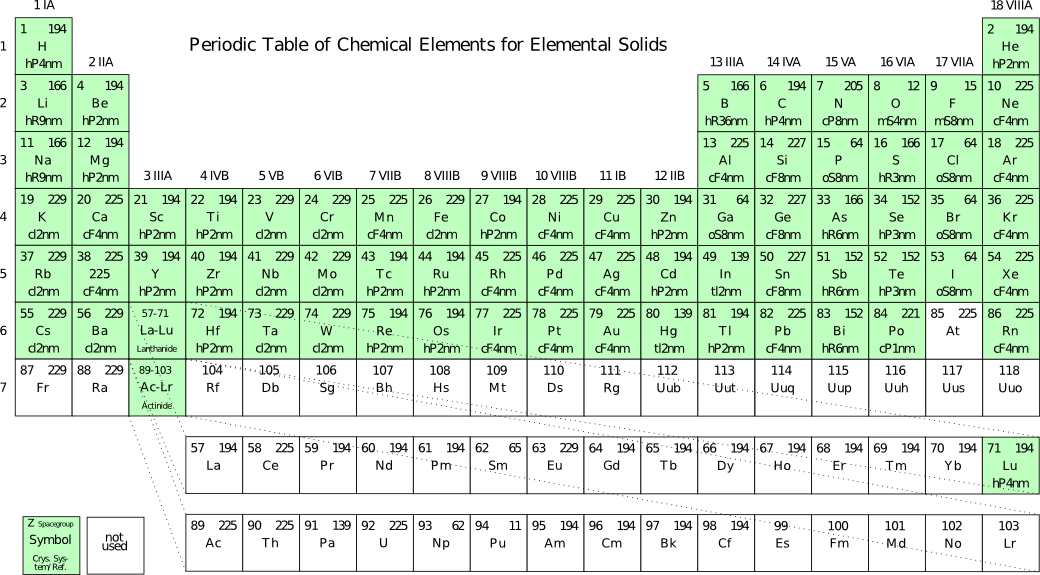

In [17]:
Image(filename='assets/error_estimates/periodic_table_elemental_solids.png')

#### References

<b>[1]</b> K. Lejaeghere et al., Science 351 (2016).<br>

### Binary systems


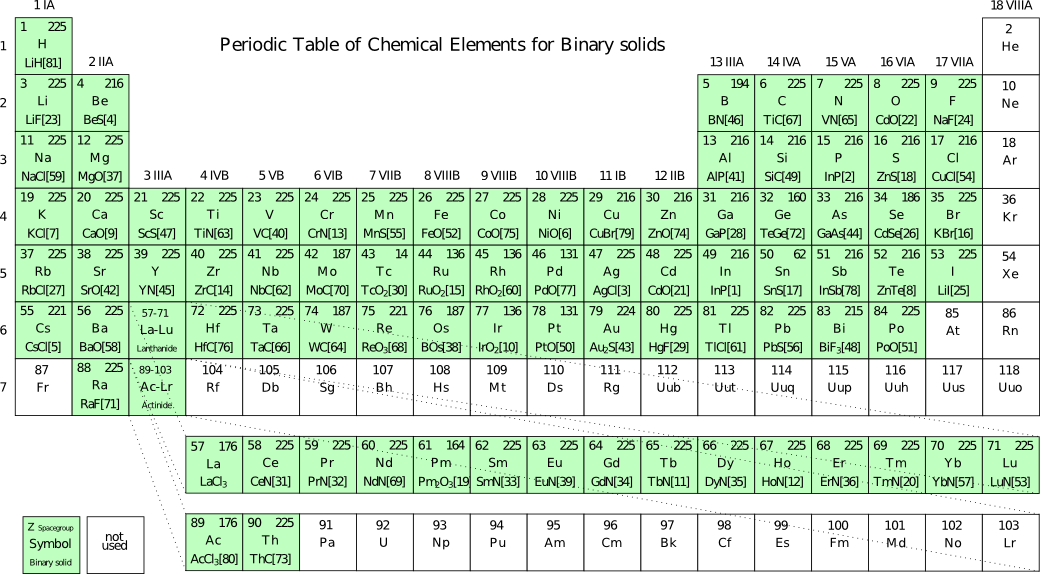

In [18]:
Image(filename='assets/error_estimates/periodic_table_binaries.png')

#### References


[1-2]
 A. M. Antyukhov. The Vegard Law in the case of solid solutions of the InP-InAs system. Inorganic Materials 22, (1986): 426-428. <br>
[3]
  V. G., Artjushenko, P. B. Baskov, V. F. Golovanov, G. M. Kuz’micheva, I. S. Lisitskii, M. D. Musina, G. V. Polyakova, V. V. Sakharov, and T. V. Sakharova. Synthesis and structural properties of AgCl(1-x)Br(x) (x= 0.5-0.8) solid solutions. Inorganic materials 41 (2005): 73-81. <br>
[4]
 H. Baaziz, Z. Charifi, F. El Haj Hassan, S. J. Hashemifar, and H. Akbarzadeh. FP-LAPW investigations of Zn(1-x)Be(x)S, Zn(1-x)Be(x)Se and Zn(1-x)Be(x)Te ternary alloys. physica status solidi (b), 243(6):1296–1305, 2006. <br>
[5]
 Z. Barnea and B. Post. Debye-Waller factors of cesium chloride. Acta Crystallographica, 21(1):181–182, Jul 1966. <br>
[6]
 C. A. Barrett and E. B. Evans. Solid solubility and lattice parameter of NiO-MnO. Journal of the American Ceramic Society, 47(10):533–533, 1964. <br>
[7]
 W. T. Barrett and W. E. Wallace. Studies of NaCl-KCl solid solutions. i. heats of formation, lattice spacings, densities, Schottky defects and mutual solubilities. Journal of the American Chemical Society, 76(2)366–369, 1954. <br>
[8]
 J.L. Baudour, M.M. Granger, L. Toupet, R. Granger, and R. Triboulet. Composition dependence of thermal vibrations in Hg(1-x)Zn(x)Te solid solutions determined by x-ray diffraction. Journal of Physics and Chemistry of Solids, 50(3):309 – 318, 1989. <br>
[9]
 A.M. Bolarn, F. Sánchez, S. Palomares, J.A. Aguilar, and G. Torres-Villaseñor. Synthesis of calcium doped lanthanum manganite by mechanosynthesis. Journal of Alloys and Compounds, 436(12):335 – 340, 2007. <br>
[10]
 A. A. Bolzan, C. Fong, B. J. Kennedy, and C. J. Howard. Structural Studies of Rutile-Type Metal Dioxides. Acta Crystallographica Section B, 53(3):373–380, Jun 1997. <br>
[11-12]
 R.C. Brown and N.J. Clark. Composition limits and vaporization behaviour of rare earth nitrides. Journal of Inorganic and Nuclear Chemistry, 36(11):2507 – 2514, 1974. <br>
[13]
 J. D. Browne, P. R. Liddell, R. Street, and T. Mills. An investigation of the antiferromagnetic transition of CrN. physica status solidi (a), 1(4):715–723, 1970. <br>
[14]
 L. D. Brownlee. The pseudo-binary systems of uranium carbide with zirconium carbide, tantalum carbide and niobium carbide. J. Inst. Metals 87 (1958). <br>
[15]
 S.R. Butler and J.L. Gillson. Crystal growth, electrical resistivity and lattice parameters of RuO2 and IrO2. Materials Research Bulletin, 6(2):81 – 89, 1971. <br>
[16]
 N. M. Butt, K. D. Rouse, M. W. Thomas, and B. T. M. Willis. Debye–Waller factors of KBr at 4.2 and 295 K. Acta Crystallographica Section A, 34(6):840–842, Nov 1978. <br>
[17]
 T. Chattopadhyay, J. Pannetier, and H.G. Von Schnering. Neutron diffraction study of the structural phase transition in SnS and SnSe. Journal of Physics and Chemistry of Solids, 47(9):879 – 885, 1986. <br>
[18]
 Xiang-Rong Chen, Xiao-Feng Li, Ling-Cang Cai, and Jun Zhu. Pressure induced phase transition in ZnS. Solid State Communications, 139(5):246 – 249, 2006. <br>
[19]
 T. D. Chikalla, C. E. McNeilly, and F. P. Roberts. Polymorphic modifications of Pm2O3. Journal of the American Ceramic Society, 55(8):428–428, 1972. <br>
[20]
 H. R. Child, M. K. Wilkinson, J. W. Cable, W. C. Koehler, and E. O. Wollan. Neutron diffraction investigation of the magnetic properties of compounds of rare-earth metals with group V anions. Phys. Rev., 131:922–931,
Aug 1963. <br>
[21-22]
 A. Cimino and M. Marezio. Lattice parameter and defect structure of cadmium oxide containing foreign atoms. Journal of Physics and Chemistry of Solids 17, no. 1-2 (1960): 57-64. <br>
[23-34]
 Pietro Cortona. Direct determination of self-consistent total energies and charge densities of solids: A study of the cohesive properties of the alkali halides. Phys. Rev. B, 46:2008–2014, Jul 1992. <br>
[25]
 R.Lindsay Davis and Colin H.L. Kennard. Thermal parameters for lithium halides. Journal of Solid State Chemistry, 64(2):217 – 219, 1986. <br>
[26]
 Suraj Deore, Fen Xu, and Alexandra Navrotsky. Oxide-melt solution calorimetry of selenides: Enthalpy of formation of zinc, cadmium, and lead selenide. American Mineralogist, 93(5-6):779–783, 2008. <br>
[27]
 V. T. Deshpande and D. B. Sirdeshmukh. Thermal expansion of ammonium bromide, rubidium bromide and rubidium chloride. Acta Crystallographica, 14(4):353–355, Apr 1961. <br>
[28]
 P. Deus, U. Voland, and H. A. Schneider. Thermal expansion of gap within 20 to 300 K. physica status solidi (a), 80(1):K29–K32, 1983. <br>
[29]
 Fritz Ebert and Hans Woitinek. Kristallstrukturen von fluoriden. ii. HgF, HgF2, CuF und CuF2. Zeitschrift für anorganische und allgemeine Chemie, 210(3):269, 1933. <br>
[30]
 Efrain E. Rodriguez, Frederic Poineau, Anna Llobet, Alfred P. Sattelberger, Joydeep Bhattacharjee, Umesh V. Waghmare, Thomas Hartmann, , and Anthony K. Cheetham. Structural studies of TcO2 by neutron powder diffraction and first-principles calculations. Journal of the American Chemical Society, 129(33):10244, 2007. <br>
[31-36]
 Peter Ettmayer, Johann Waldhart, Alfred Vendl, and Gerhard Banik. Über die mischbarkeit von ThC mit LaN, CeN, PrN, NdN, SmN, GdN und ErN. Monatshefte für Chemie / Chemical Monthly, 111(5):1185, 1980. <br>
[37]
 C.M. Fang and G. de With. Crystal structure and chemical bonding of the high-pressure phase of MgAl2O4 from first-principles calculations. Philosophical Magazine A 82(15):2885, OCT 2002. <br>
[38]
 Boniface P.T. Fokwa, Patrick R.N. Misse, Michael Gilleßen, and Richard Dronskowski. Sn-flux syntheses, characterizations and bonding analyses of OsB and TiB2. Journal of Alloys and Compounds, 489(2):339 – 342, 2010. <br>
[39]
 R. J. Gambino, R. R. Ruf, T. R. McGuire, and P. Fumagalli. Magnetic, magnetooptic, and transport properties of Tb-doped EuS films. Journal of Applied Physics, 70(10):6386–6388, 1991. <br>
[40]
 J. Gatterer, G. Dufek, P. Ettmayer, and R. Kieffer. Das kubische Tantalmononitrid (B 1-Typ) und seine Mischbarkeit mit den isotypen Übergangsmetallnitriden und-carbiden. Monatshefte für Chemie / Chemical Monthly,
106(5):1137–1147, 1975. <br>
[41]
 V. Geist and C. Ascheron. The proton-induced kossel effect and its application to crystallographic studies. Crystal Research and Technology, 19(9):1231, 1984. <br>
[42]
 Yun-Dong Guo, Xin-Lu Cheng, Li-Ping Zhou, Zi-Jiang Liu, and Xaing-Dong Yang. First-principles calculation of elastic and thermodynamic properties of MgO and SrO under high pressure. Physica B: Condensed Matter,
373(2):334 – 340, 2006. <br>
[43]
H. Hirsch, A. Decugnac, M. C. Gadet, and J. Pouradier. Cristallographie du sulfure aureux. Comptes rendus hebdomadaries des seances de l'Academie des sciences Serie B 263: 1328, 1966 . <br>
[44]
 E. F. Hockings, I. Kudman, T. E. Seidel, C. M. Schmelz, and E. F. Steigmeier. Thermal and electrical transport in InAs-GaAs alloys. Journal of Applied Physics, 37(7):2879–2887, 1966. <br>
[45]
 H. Holleck and E. Smailos. Mischnitride von thorium mit seltenen erden. Journal of Nuclear Materials, 91(1):237 – 239, 1980. <br>
[46]
 Qianku Hu, Qinghua Wu, Yanming Ma, Lijun Zhang, Zhongyuan Liu, Julong He, Hong Sun, Hui-Tian Wang, and Yongjun Tian. First-principles studies of structural and electronic properties of hexagonal Bc5. Phys. Rev. B, 73:214116, Jun 2006. <br>
[47]
 F. Hulliger and G.W. Hull Jr. Superconductivity in rocksalt-type compounds. Solid State Communications, 8(17):1379 – 1382, 1970. <br>
[48]
 F. Hund and R. Fricke. Der kristallbau von alpha-BiF3. Zeitschrift für anorganische Chemie, 258(3-5):198, 1949. <br>
[49]
 R.J Iwanowski, K Fronc, W Paszkowicz, and M Heinonen. XPS and XRD study of crystalline 3C-SiC grown by sublimation method. Journal of Alloys and Compounds, 286(12):143 147, 1999. <br>
[50]
 Walter J. Moore Jr. and Linus Pauling. The crystal structures of the tetragonal monoxides of lead, tin, palladium, and platinum. Journal of the American Chemical Society, 63(5):1392–1394, 1941. <br>
[51]
 V Kanchana, G Vaitheeswaran, A Svane, and A Delin. First-principles study of elastic properties of CeO2, ThO2, and PoO2. Journal of Physics: Condensed Matter, 18(42):9615, 2006. <br>
[52]
 Takashi Katsura, Bunji Iwasaki, Shigeyuki Kimura, and Syuniti Akimoto. High-pressure synthesis of the stoichiometric compound FeO. The Journal of Chemical Physics, 47(11):4559–4560, 1967. <br>
[53]
 Helmuth Klesnar and Peter Rogl. Phase relations in the ternary systems NdBN, SmBN, and GdBN. Journal of the American Ceramic Society, 75(10):2825–2827, 1992. <br>
[54]
 B. R. Lawn. The thermal expansion of silver iodide and the cuprous halides. Acta Crystallographica, 17(11):1341–1347, Nov 1964. <br>
[55]
 C.-H. Leung and L.H. Van Vlack. Solubility limits in binary (Ca,Mn) chalcogenides. Journal of the American Ceramic Society, 62(11-12):613–616, 1979. <br>
[56]
 V. Leute, A. Behr, C. Hünting, and H.M. Schmidtke. Phase diagram and diffusion properties of the quasi-binary system (Sn,Pb)S. Solid State Ionics, 68(34):287 – 294, 1994. <br>
[57]
 D.X. Li, A. Oyamada, K. Hashi, Y. Haga, T. Matsumura, H. Shida, T. Suzuki, T. Kasuya, A. Dönni, and F. Hulliger. Study of physical properties of Yb-monopnictides. Journal of Magnetism and Magnetic Materials, 140144, Part 2:1169 – 1170, 1995. International Conference on Magnetism. <br>
[58]
 Tieyu Lv, Deyan Chen, and Meichun Huang. Quasiparticle band structures of BaO and BaS. Journal of Applied Physics, 100(8), 2006. <br>
[59]
 D. R. McCann, L. Cartz, R. E. Schmunk, and Y. D. Harker. Compressibility of hexagonal selenium by x-ray and neutron diffraction. Journal of Applied Physics, 43(4):1432, 1972. <br>
[60]
 Olaf Muller and Rustum Roy. Formation and stability of the platinum and rhodium oxides at high oxygen pressures and the structures of pt3o4, -pto2 and rho2. Journal of the Less Common Metals, 16(2):129 – 146, 1968. <br>
[61]
 T. Müürsepp and A. Haav. X-ray diffraction study of the systems TlI-CsI, TlI-RbI, and TlI-TlCl. Physica Status Solidi (a), 21(2):K81–K83, 1974. <br>
[62]
 Kazumasa Nakamura and Masatomo Yashima. Crystal structure of NaCl-type transition metal monocarbides {MC} (M = V, Ti, Nb, Ta, Hf, Zr), a neutron powder diffraction study. Materials Science and Engineering: B, 148(13):69, 2008. First International Conference on the Science and Technology for Advanced Ceramics (STAC) in conjunction with the Second International Conference on Joining Technology for new Metallic Glasses and Inorganic Materials (JTMC). <br>
[63]
 G. Neumann, R. Kieffer, and P. Ettmayer. Über das system TiC-TiN-Tio. Monatshefte für Chemie / Chemical Monthly, 103(4):1130–1137, 1972. <br>
[64]
 Katharine Page, Jun Li, Robert Savinelli, Holly N. Szumila, Jinping Zhang, Judith K. Stalick, Thomas Proffen, Susannah L. Scott, and Ram Seshadri. Reciprocal-space and real-space neutron investigation of nanostructured Mo2C and WC. Solid State Sciences, 10(11):1499 – 1510, 2008. <br>
[65-66]
 N. Pessall, R.E. Gold, and H.A. Johansen. A study of superconductivity in interstitial compounds. Journal of Physics and Chemistry of Solids, 29(1):19, 1968. <br>
[67]
 J. Pflüger, J. Fink, W. Weber, K. P. Bohnen, and G. Crecelius. Dielectric properties of TiC(x), TiN(x), VC(x), and VN(x) from 1.5 to 40 eV determined by electron-energy-loss spectroscopy. Phys. Rev. B, 30:1155–1163, Aug 1984. <br>
[68]
 Efrain E. Rodriguez, Anna Llobet, Thomas Proffen, Brent C. Melot, Ram Seshadri, Peter B. Littlewood, and Anthony K. Cheetham. The role of static disorder in negative thermal expansion in ReO3. Journal of Applied Physics, 105(11), 2009. <br>
[69]
 P Schobinger-Papamantellos, P Fischer, O Vogt, and E Kaldis. Magnetic ordering of neodymium monopnictides determined by neutron diffraction. Journal of Physics C: Solid State Physics, 6(4):725, 1973. <br>
[70]
 N. Schönberg. The tungsten carbide and nickel arsenide structures. Acta Metallurgica 2: 427-432, 1954.<br>
[71]
 GER Schulze.  The crystal structure of radium fluoride. - Zeitschrift für Physikalische Chemie-Abteilung B-Chemie Der Elementarprozesse Aufbau Der Materie, 32(6):430, MAY 1936. <br>
[72]
 J. Stoemenos, S. Kokkou, and N. A. Economou. On the superstructure of germanium telluride single crystalline films. physica status solidi (a), 13(1):265–275, 1972. <br>
[73]
 R.S. Street and T.N. Waters. The UC/UN and ThC/ThN systems. Journal of the Less Common Metals, 5(3):295 – 297,1963. <br>
[74]
 X.W. Sun, Z.J. Liu, Q.F. Chen, H.W. Lu, T. Song, and C.W. Wang. Heat capacity of ZnO with cubic structure at high temperatures. Solid State Communications, 140(5):219 – 224, 2006. <br>
[75]
 N.C. Tombs and H.P Rooksby. Structure of Monoxides of some Transition Elements at Low Temperatures. Nature, 165(4194):442–443, mar 1950. 10.1038/165442b0. <br>
[76]
 V. Valvoda. X-ray Debye temperatures of HfC and alpha-W2C. physica status solidi (a), 83(2):K123–K125, 1984. <br>
[77]
 J. Waser, H. A. Levy, and S. W. Peterson. The structure of PdO. Acta Crystallographica, 6(7):661–663, Jul 1953. <br>
[78]
 J.C. Woolley and D.G. Lees. Equilibrium diagrams with InSb as one component. Journal of the Less Common Metals, 1(3):192 – 198, 1959. <br>
[79]
 Ralph W. G. Wyckoff and Eugen Posnjak. The crystal structures of the cuprous halides. Journal of the American Chemical Society, 44(1):30–36, 1922. <br>
[80]
 W. H. Zachariasen. Crystal chemical studies of the 5f-series of elements. I. New structure types. Acta Crystallographica, 1(5):265–268, Nov 1948. <br>
[81]
 W. Bruce Zimmerman. Lattice-constant dependence on isotopic composition in the Li(h, d) system. Phys. Rev. B, 5:4704–4707, Jun 1972. <br> 

# Data Browser: Analyzing the Curated Reference Data Set


<div style="max-width: 900px;">
<p>The next cells allow to inspect the deviations occurring in total and relative energy as function of the numerical settings.</p><br>
The interface below allows you to explore the error due to numerical settings for the 71 elementary solids and the 82 binary systems. Use the drop-down menus to choose a code, a property, and the (code-specific) numerical settings; the <i>Add el. solids/binaries</i> buttons then generate the plots. The upper plots  show the errors (deviations) with respect to highly converged settings for the elemental solids (left) and binaries (right). For the elemental solids, an additional, color-coded periodic table is shown below. The color of the elements relates to the error.<br><br>

Click on <i>Instructions</i> for further details and explanations.
</div>

<details>
    <summary>
        <div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;"><b>Instructions (click to expand)</b></div></summary>
The settings available for all 4 electronic structure codes are the choice of the <i>exchange-correlation (XC) functional</i> and the <i>k-point density</i>. The choices for the XC-functional are a parametrization of the local densiy approximation (LDA) and the general gradient approximation xc-functional PBE (Perdew-Berke-Enzerhoff). For further details the reader is referred to the literature. The k-point density gives the number of k-points per inverse Angstrom used to sample the Brillouin-Zone.<br>
Due to the different methods used in the codes additional numerical settings are required.<br>
<b>GPAW</b>: <i>Plain Wave (PW) cutoff</i> in eV. For further details see: <a href="https://wiki.fysik.dtu.dk/gpaw/documentation/manual.html">GPAW manual</a> <br>
<!-- <b>VASP</b>: <i>Precision settings</i>, that include pseudo-potential and plain wave cutoff, For further details see:  <a href="https://cms.mpi.univie.ac.at/wiki/index.php/Main_page">VASP manual</a> <br> -->
<b>FHI-aims</b>: The density of the integration grid used for the numerically tabulated atomic orbitals are selected by <i> Integration grid</i>. The number of atom centered basis function is selected by <i>Tiers</i>. Additionally two choices for the treatment of relativistic effects are available with <i>Relativity treatment</i>. For more details see: <a href="https://aimsclub.fhi-berlin.mpg.de/">Aims club</a><br>
   <b>exciting:</b>  <i>Precision</i> describes the basis set size using the computational parameter <i>rgkmax</i> (see <a href="http://exciting-code.org/documentation">exciting documentation</a>). <i>Precision = rgkmax/rgkmax<sub>norm</sub></i>, where <i>rgkmax<sub>norm</sub></i> is chosen to be the <i>rgkmax</i>-value which results in an error of 10<sup>-4</sup> eV in total energy per atom. <br>
It is possible to inspect errors/deviations in total energy, relative energy, and cohesive energy (Drop down menu <i>Quantity</i>). Relative energies
are computed as a total energy difference with respect to a cell volume increase of 5%. This allows to explore the effect of error cancellation. Additionally you can explore the error in the cohesive energy for the binary systems. We define the cohesive energy as the total energy of the binary systems minus the the total energy of its constituents in their elemental solid structure, divided by the number of atoms in the binary cell. 
<br><br>
The settings for the reference calculations are:<br>
<!--   -VASP: 8 k-points·Å, Accurate<br> -->
   -exciting: 8 k-points·Å, 90 % Precision<br>
   -GPAW: 8 k-points·Å, 1600eV (PW cutoff)<br>
   -FHI-aims: 8 k-points·Å, really tight, tier2<br>
</div>    


In [19]:
%%html
<script>
var kernel = Jupyter.notebook.kernel;
  
// Adds an option to a dropdown menu
function addDropdownChoice(dropdown, value, content) {
    var el = document.createElement('option');
    el.value = value;
    el.innerHTML = content
    dropdown.appendChild(el);
}
  
// Adds an option to a dropdown menu with selection
function addDropdownChoice_selection(dropdown, value, content, selected) {
    var el = document.createElement('option');
    el.value = value;
    el.innerHTML = content
    el.selected = selected
    dropdown.appendChild(el);
}
  
function errorUpdateForm() {
    var code = document.getElementById("error_estimates_code").value;
    var kpt = document.getElementById("error_estimates_kdensity");
    var dprec = document.getElementById("error_estimates_precision_name");
    var dtiers = document.getElementById("error_estimates_tiers_name");
    var pprec   = document.getElementById("error_estimates_precision"); pprec.innerHTML = '';
    var prel  = document.getElementById("error_estimates_relativity"); prel.innerHTML = '';
    var ptiers  = document.getElementById("error_estimates_tiers"); ptiers.innerHTML = '';
    var pxc  = document.getElementById("error_estimates_xcfunctional"); pxc.innerHTML = '';
    var pplot  = document.getElementById("error_estimates_quantity"); pplot.innerHTML = '';
    var baddbins  = document.getElementById("btn_addbins");
    var bclbins  = document.getElementById("btn_clearbins");
    var bcllbins  = document.getElementById("btn_clearlastbins");

    // -----------------------------------------------------------
    // rebuild kpt drop down with old selection
    // coming from exciting, this needs to be done because exciting has currently fewer choices
    var selected2 = ""
    var selected4 = ""
    var selected8 = ""
    switch(kpt.value) {
      case "2":
        selected2 = "selected"
        break;
      case "4":
        selected4 = "selected"
        break;
      case "8":
        selected8 = "selected"
        break;
    }
    kpt.innerHTML = '';
    addDropdownChoice_selection(kpt, "2", "2 Å", selected2);
    addDropdownChoice_selection(kpt, "4", "4 Å", selected4);
    addDropdownChoice_selection(kpt, "8", "8 Å", selected8);
    // -----------------------------------------------------------
    switch(code) {
      //case "VASP": 
      //  dprec.innerHTML = 'Precision:';
      //  dtiers.innerHTML = 'POTCAR:';
      //  addDropdownChoice(pprec, "Low", "Low");
      //  addDropdownChoice(pprec, "Normal", "Normal");
      //  addDropdownChoice(pprec, "Accurate", "Accurate");
      //  addDropdownChoice(pxc, "PBE", "PBE");
      //  addDropdownChoice(pxc, "LDA", "LDA");
      //  addDropdownChoice(ptiers, "recommended", "recommended");
      //  addDropdownChoice(ptiers, "POTCAR", "POTCAR");
      //  addDropdownChoice(ptiers, "POTCAR_s", "POTCAR_s");
      //  addDropdownChoice(ptiers, "POTCAR_pv", "POTCAR_pv");
      //  addDropdownChoice(ptiers, "POTCAR_sv", "POTCAR_sv");
      //  addDropdownChoice(ptiers, "POTCAR_d", "POTCAR_d");
      //  addDropdownChoice(ptiers, "POTCAR_h", "POTCAR_h");
      //  addDropdownChoice(pplot, "E_tot", "Total Energy");
      //  addDropdownChoice(pplot, "relR", "relative Energy");
      //  addDropdownChoice(pplot, "E_coh", "Cohesive Energy (binaries)");
      //  baddbins.disabled= false;
      //  bclbins.disabled= false;
      //  bcllbins.disabled= false;
      //  errorUpdateForm_k();
      //  errorUpdateForm_tiers();
      //  errorUpdateForm_precision()
      //  break;
        
      case "FHI-aims":  
        dprec.innerHTML = 'Integration grid';
        dtiers.innerHTML = 'Tiers:';
        addDropdownChoice(pprec, "light", "light");
        addDropdownChoice(pprec, "tight", "tight");
        addDropdownChoice(pprec, "really_tight", "really tight");
        addDropdownChoice(prel, "atomic_zora", "atomic zora");
        addDropdownChoice(prel, "zora", "zora");
        addDropdownChoice(ptiers, "minimal", "minimal");
        addDropdownChoice(ptiers, "standard", "standard");
        addDropdownChoice(ptiers, "tier1", "tier1");
        addDropdownChoice(ptiers, "tier2", "tier2");
        addDropdownChoice(pxc, "pbe", "PBE");
        addDropdownChoice(pxc, "pw-lda", "LDA");
        addDropdownChoice(pplot, "E_tot", "Total Energy");
        addDropdownChoice(pplot, "relR", "relative Energy");
        addDropdownChoice(pplot, "E_coh", "Cohesive Energy (binaries)");
        break;

      case "exciting": 
        dprec.innerHTML = 'Precision:';
        dtiers.innerHTML = '';
        kpt.innerHTML = '';
        addDropdownChoice(kpt, "8", "8 Å");
        addDropdownChoice(pprec, "30", "30 %");
        addDropdownChoice(pprec, "40", "40 %");
        addDropdownChoice(pprec, "50", "50 %");
        addDropdownChoice(pprec, "60", "60 %");
        addDropdownChoice(pprec, "70", "70 %");
        addDropdownChoice(pprec, "80", "80 %");
        addDropdownChoice(pxc, "PBE", "PBE");
        addDropdownChoice(pplot, "E_tot", "Total Energy");
        //addDropdownChoice(pplot, "relR", "relative Energy");
        addDropdownChoice(pplot, "E_coh", "Cohesive Energy (binaries)");
        baddbins.disabled= false;
        bclbins.disabled= false;
        bcllbins.disabled= false;
        break;
        
      case "GPAW": 
         dprec.innerHTML = 'PW cutoff:';

        addDropdownChoice(pprec, "300", "300 eV");
        addDropdownChoice(pprec, "400", "400 eV");
        addDropdownChoice(pprec, "500", "500 eV");
        addDropdownChoice(pprec, "600", "600 eV");
        addDropdownChoice(pprec, "700", "700 eV");
        addDropdownChoice(pprec, "800", "800 eV");
        addDropdownChoice(pprec, "1000", "1000 eV");
        addDropdownChoice(pprec, "1100", "1100 eV");
        addDropdownChoice(pprec, "1200", "1200 eV");
        addDropdownChoice(pprec, "1300", "1300 eV");
        addDropdownChoice(pprec, "1400", "1400 eV");
        addDropdownChoice(pprec, "1600", "1600 eV");
        addDropdownChoice(pxc, "pbe", "PBE");
        addDropdownChoice(pplot, "E_tot", "Total Energy");
        addDropdownChoice(pplot, "relR", "relative Energy");
        addDropdownChoice(pplot, "E_coh", "Cohesive Energy (binaries)");
        baddbins.disabled= false;
        bclbins.disabled= false;
        bcllbins.disabled= false;
        break;


    }
  }

  function errorUpdateForm_k() {
    var code = document.getElementById("error_estimates_code").value;
    var tiers = document.getElementById("error_estimates_tiers").value;
    var kpt = document.getElementById("error_estimates_kdensity").value;
    var pprec   = document.getElementById("error_estimates_precision"); 
    var pplot  = document.getElementById("error_estimates_quantity"); 
    var baddbins  = document.getElementById("btn_addbins");
    var bclbins  = document.getElementById("btn_clearbins");
    var bcllbins  = document.getElementById("btn_clearlastbins");
    var prec   = document.getElementById("error_estimates_precision").value;
    var pxc  = document.getElementById("error_estimates_xcfunctional");
    //if(code=="VASP" && tiers=="recommended" && kpt=="8"){
    //    pprec.innerHTML = '';
    //    addDropdownChoice(pprec, "Accurate", "Accurate");
    //    addDropdownChoice(pprec, "Low", "Low");
    //    addDropdownChoice(pprec, "Normal", "Normal");
    //    addDropdownChoice(pprec, "130%", "130%");
    //    addDropdownChoice(pprec, "150%", "150%");
    //    addDropdownChoice(pprec, "175%", "175%");
    //    addDropdownChoice(pprec, "200%", "200%");
    //    addDropdownChoice(pprec, "225%", "225%");
    //
    //}
    //else if(code=="VASP" && (tiers!="recommended" || kpt!="8")){
    //    pprec.innerHTML = '';
    //    pplot.innerHTML = '';
    //    addDropdownChoice(pprec, "Accurate", "Accurate");
    //    addDropdownChoice(pprec, "Low", "Low");
    //    addDropdownChoice(pprec, "Normal", "Normal");
    //    addDropdownChoice(pplot, "E_tot", "Total Energy");
    //    addDropdownChoice(pplot, "relR", "relative Energy");
    //    addDropdownChoice(pplot, "E_coh", "Cohesive Energy (binaries)");
    //}
    //if(code=="VASP" && tiers=="recommended" && (prec=="Low" || prec=="Normal" || prec=="Accurate")){
    //    baddbins.disabled= false;
    //    bclbins.disabled= false;
    //    bcllbins.disabled= false;
    //    pxc.innerHTML = '';
    //    addDropdownChoice(pxc, "PBE", "PBE");
    //    addDropdownChoice(pxc, "LDA", "LDA");
    //}
    // else if(code=="VASP" && (tiers!="recommended" || (prec!="Low" && prec!="Normal" && prec!="Accurate"))){
    //    baddbins.disabled= true;
    //    bclbins.disabled= true;
    //    bcllbins.disabled= true;
    //    pxc.innerHTML = '';
    //    addDropdownChoice(pxc, "PBE", "PBE");
    //} 
  }
  
  function errorUpdateForm_tiers() {
    var code = document.getElementById("error_estimates_code").value;
    var tiers = document.getElementById("error_estimates_tiers").value;
    var kpt = document.getElementById("error_estimates_kdensity").value;
    var pprec   = document.getElementById("error_estimates_precision"); 
    var pplot  = document.getElementById("error_estimates_quantity"); 
    var baddbins  = document.getElementById("btn_addbins");
    var bclbins  = document.getElementById("btn_clearbins");
    var bcllbins  = document.getElementById("btn_clearlastbins");
    var prec   = document.getElementById("error_estimates_precision").value;
    var pxc  = document.getElementById("error_estimates_xcfunctional");
    //if(code=="VASP" && tiers=="recommended" && kpt=="8"){
    //    pprec.innerHTML = '';
    //    
    //    addDropdownChoice(pprec, "Low", "Low");
    //    addDropdownChoice(pprec, "Normal", "Normal");
    //    addDropdownChoice(pprec, "Accurate", "Accurate");
    //    addDropdownChoice(pprec, "130%", "130%");
    //    addDropdownChoice(pprec, "150%", "150%");
    //    addDropdownChoice(pprec, "175%", "175%");
    //    addDropdownChoice(pprec, "200%", "200%");
    //    addDropdownChoice(pprec, "225%", "225%");
//
    //}
    //else if(code=="VASP" && (tiers!="recommended" || kpt!="8")){
    //    pprec.innerHTML = '';
    //    pplot.innerHTML = '';
    //    addDropdownChoice(pprec, "Accurate", "Accurate");
    //    addDropdownChoice(pprec, "Low", "Low");
    //    addDropdownChoice(pprec, "Normal", "Normal");
    //    addDropdownChoice(pplot, "E_tot", "Total Energy");
    //    addDropdownChoice(pplot, "relR", "relative Energy");
    //    addDropdownChoice(pplot, "E_coh", "Cohesive Energy (binaries)");
    //}
    //if(code=="VASP" && tiers=="recommended" && (prec=="Low" || prec=="Normal" || prec=="Accurate")){
    //    baddbins.disabled= false;
    //    bclbins.disabled= false;
    //    bcllbins.disabled= false;
    //    pxc.innerHTML = '';
    //    addDropdownChoice(pxc, "PBE", "PBE");
    //    addDropdownChoice(pxc, "LDA", "LDA");
    //}
    //else if(code=="VASP" && (tiers!="recommended" || (prec!="Low" && prec!="Normal" && prec!="Accurate"))){
    //    baddbins.disabled= true;
    //    bclbins.disabled= true;
    //    bcllbins.disabled= true;
    //    pxc.innerHTML = '';
    //    addDropdownChoice(pxc, "PBE", "PBE");
    //}
  } 
  
  function errorUpdateForm_precision() {
    var code = document.getElementById("error_estimates_code").value;
    var tiers = document.getElementById("error_estimates_tiers").value;
    var kpt = document.getElementById("error_estimates_kdensity").value;
    var prec   = document.getElementById("error_estimates_precision").value; 
    var pprec   = document.getElementById("error_estimates_precision"); 
    var pplot  = document.getElementById("error_estimates_quantity"); 
    var baddbins  = document.getElementById("btn_addbins");
    var bclbins  = document.getElementById("btn_clearbins");
    var bcllbins  = document.getElementById("btn_clearlastbins");
    var pxc  = document.getElementById("error_estimates_xcfunctional");
    //if(code=="VASP" && (prec!="Low" && prec!="Normal" && prec!="Accurate")){
    //    pplot.innerHTML = '';
    //    addDropdownChoice(pplot, "E_tot", "Total Energy");
    //}
    //else if(code=="VASP" && (tiers!="recommended" || kpt!="8")){
    //    pplot.innerHTML = '';
    //    addDropdownChoice(pplot, "E_tot", "Total Energy");
    //    addDropdownChoice(pplot, "relR", "relative Energy");
    //    addDropdownChoice(pplot, "E_coh", "Cohesive Energy (binaries)");
//
    //}
    //if(code=="VASP" && tiers=="recommended" && (prec=="Low" || prec=="Normal" || prec=="Accurate")){
    //    baddbins.disabled= false;
    //    bclbins.disabled= false;
    //    bcllbins.disabled= false;
    //    pxc.innerHTML = '';
    //    addDropdownChoice(pxc, "PBE", "PBE");
    //    addDropdownChoice(pxc, "PBE", "LDA");
    //}
    //else if(code=="VASP" && (tiers!="recommended" || (prec!="Low" && prec!="Normal" && prec!="Accurate"))){
    //    baddbins.disabled= true;
    //    bclbins.disabled= true;
    //    bcllbins.disabled= true;
    //    pxc.innerHTML = '';
    //    addDropdownChoice(pxc, "PBE", "PBE");
    //}
  } 
  
  function add_monomers() {
    var command = 
          'ctrl_xc = "' + document.getElementById("error_estimates_xcfunctional").value + 
        '"; ctrl_kpt = ' + document.getElementById("error_estimates_kdensity").value +
        '; ctrl_prec = "' + document.getElementById("error_estimates_precision").value +
        '"; ctrl_tiers = "' + document.getElementById("error_estimates_tiers").value +
        '"; ctrl_rel = "' + document.getElementById("error_estimates_relativity").value +
        '"; ctrl_quant = "' + document.getElementById("error_estimates_quantity").value +
        '"; ctrl_code = "' + document.getElementById("error_estimates_code").value +
        '"; ctrl_button = 1';
    kernel.execute(command);
    window.runCells("exe_cell");
    window.runCells("ptablecell");
  }
  function clear_last() {
    var command = 'ctrl_button = 2';
    kernel.execute(command);
    window.runCells("exe_cell");
  }
  function clear_plot() {
    var command = 'ctrl_button = 3';
    kernel.execute(command);
    window.runCells("exe_cell");
  }
  function add_binaries() {
    var command = 
          'ctrl_xc = "' + document.getElementById("error_estimates_xcfunctional").value + 
        '"; ctrl_kpt = "' + document.getElementById("error_estimates_kdensity").value +
        '"; ctrl_prec = "' + document.getElementById("error_estimates_precision").value +
        '"; ctrl_tiers = "' + document.getElementById("error_estimates_tiers").value +
        '"; ctrl_rel = "' + document.getElementById("error_estimates_relativity").value +
        '"; ctrl_quant = "' + document.getElementById("error_estimates_quantity").value +
        '"; ctrl_code = "' + document.getElementById("error_estimates_code").value +
        '"; ctrl_button = 4';
    kernel.execute(command);
    window.runCells("exe_cell");
  }
  function clear_last_bins() {
    var command = 'ctrl_button = 5';
    kernel.execute(command);
    window.runCells("exe_cell");
  }
  function clear_plot_bins() {
    var command = 'ctrl_button = 6';
    kernel.execute(command);
    window.runCells("exe_cell");
  }
</script>

<style type="text/css">
  
  .error_table th { font-weight: bold; padding-right: 2ex; }
  .error_table td input { margin-right: 1ex; }
  
</style>

<!-- Controls area -->

<div class="error_control">
  <table class="error_table">
    
    <tr>
      <th>XC-Functional:</th>
      <td>
        <select id="error_estimates_xcfunctional">
          <option value="pbe" selected>PBE</option>
        </select>
      </td>
      <td id="error_estimates_xcfunctional_description" style="white-space: pre;"></td>
      <th>k-point density:</th>
      <td>
        <select id="error_estimates_kdensity" onchange="errorUpdateForm_k()" >
          <option value="2">2 Å</option>
          <option value="4">4 Å</option>    
          <option value="8" selected>8 Å</option>  
        </select>
      </td>
      <td id="error_estimates_kdensity_description" style="white-space: pre;"></td>
      <th id="error_estimates_precision_name">PW cutoff:</th>
      <td>
        <select id="error_estimates_precision"  onchange="errorUpdateForm_precision()">
          <option value="300">300 eV</option>
          <option value="400">400 eV</option>
          <option value="500">500 eV</option>
          <option value="600" selected>600 eV</option>
          <option value="700">700 eV</option>
          <option value="800">800 eV</option>
          <option value="1000">1000 eV</option>
          <option value="1100">1100 eV</option>
          <option value="1200">1200 eV</option>
          <option value="1300">1300 eV</option>
          <option value="1400">1400 eV</option>
          <option value="1600">1600 eV</option>  
        </select>
      </td>
      <td id="error_estimates_precision_description" style="white-space: pre;"></td>
    </tr>
    <tr>
      <th id="error_estimates_tiers_name">Tiers:</th>
      <td>
        <select id="error_estimates_tiers"  onchange="errorUpdateForm_tiers()"><!-- content inserted programmatically --></select>
      </td>
      <td id="error_estimates_tiers_description" style="white-space: pre;"></td>
       <th>Relativity treatment:</th>
      <td><select id="error_estimates_relativity" ><!-- content inserted programmatically --></select></td>
      <td id="error_estimates_relativity_description" style="white-space: pre;"></td>
      <th>Code:</th>
      <td><select id="error_estimates_code" onchange="errorUpdateForm()">
        <option value="GPAW">GPAW</option>
        <option value="FHI-aims">FHI-aims</option>
<!--        <option value="VASP">VASP</option>  -->
        <option value="exciting">exciting</option> 
      </select></td>
      <td id="error_estimates_code_description" style="white-space: pre;"></td>
    </tr>   
    
    <tr>
      <th>Quantity:</th>
      <td><select id="error_estimates_quantity">
        <option value="E_tot">Total Energy</option>
        <option value="relR">relative Energy</option>
        <option value="E_coh">Cohesive Energy (binaries)</option>
        </select></td>
      <td id="error_estimates_quantity_description" style="white-space: pre;"></td>   
    


    </tr>
    
  </table>
  
  <table class="error_table">
    
    <tr>
      <th><button type="button" class="btn btn-primary" style="margin-top: 2ex;" onclick="add_monomers();">Add el. solids</button></th>
      <th><button type="button" class="btn clear-primary" style="margin-top: 2ex;" onclick="clear_plot();">Clear el. solids </button></th>
      <th><button type="button" class="btn clearlast-primary" style="margin-top: 2ex;" onclick="clear_last();">Clear last el. solids</button></th>
      <th><button id="btn_addbins" type="button" class="btn btn-secondary" style="margin-top: 2ex;" onclick="add_binaries();">Add binaries</button></th>
      <th><button id="btn_clearbins" type="button" class="btn clear-secondary" style="margin-top: 2ex;" onclick="clear_plot_bins();">Clear binaries</button></th>
      <th><button id="btn_clearlastbins" type="button" class="btn clearlast-secondary" style="margin-top: 2ex;" onclick="clear_last_bins();">Clear last binaries</button></th>
    </tr>
  </table>
</div>

In [ ]:
"""Add a new set of points (error or relative error) to the left plot"""
# Code specific parameters:
keys, ref_keys = get_keys(ctrl_code,ctrl_prec,ctrl_kpt,ctrl_xc,ctrl_tiers,ctrl_rel)

if ctrl_button==1:
    ctrl_sys = 'monomers'
    # Database for code
    db_con = con_code[ctrl_code,ctrl_sys]
    # el. solids or binaries
    mono_or_bin=ref_dict_binaries[ctrl_sys]
    # The plot label generated from the settings of the drop down menus
    lab=ctrl_quant+', '+ctrl_code+', '+', '.join(array(keys).tolist())
    # Error:
    if ctrl_quant=='E_tot'or ctrl_quant=='E_coh':
        lab='E_tot, '+ctrl_code+', '+', '.join(array(keys).tolist())
        if ctrl_code=='FHI-aims':
            ref_data=data_ref[ctrl_code,ctrl_sys+name_base[ctrl_code],ref_keys[0],ref_keys[1]]
        #elif ctrl_code=='VASP' and ctrl_tiers!='recommended':
        #    ref_data=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code,
        #              ctrl_sys+name_base[ctrl_code],['Accurate', 8, keys[2], keys[3]],
        #              recommended,name_dict_monos_gpaw,name_dict_bins_gpaw) 
        #elif ctrl_code=='VASP' and ctrl_kpt=='8':
        #    ref_data=get_data(con_VASP_ref, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code,
        #              ctrl_sys+name_base[ctrl_code],
        #              ['Accurate_250', '8', keys[2], keys[3]],recommended,name_dict_monos_gpaw,name_dict_bins_gpaw) 
        else:
            ref_data=data_ref[ctrl_code,ctrl_sys+name_base[ctrl_code],ref_keys[0]]
        #if ctrl_code=='VASP' and ctrl_kpt=='8' and (ctrl_prec!='Low' and ctrl_prec!='Normal' and               
        #                                                      ctrl_prec!='Accurate'):
        #    data=get_data(con_VASP_ref, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code,
        #              ctrl_sys+name_base[ctrl_code],
        #              ['Accurate_'+ctrl_prec.split('%')[0], 8, keys[2], keys[3]],
        #              recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
        #else:
        data=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code,
                          ctrl_sys+name_base[ctrl_code],keys, recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
        xylist[len(xylist)]=get_xy(Z[mono_or_bin], N[mono_or_bin], ref_data, data),lab     
    # Relative error
    else:
        if ctrl_code=='FHI-aims':
           ref_data=(data_ref[ctrl_code,ctrl_sys+name_base_expanded[ctrl_code],ref_keys[0],ref_keys[1]]-
                     data_ref[ctrl_code,ctrl_sys+name_base[ctrl_code],ref_keys[0],ref_keys[1]])
        else:      
           ref_data=(data_ref[ctrl_code,ctrl_sys+name_base_expanded[ctrl_code],ref_keys[0]]-
                     data_ref[ctrl_code,ctrl_sys+name_base[ctrl_code],ref_keys[0]])
        data_one=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code, 
                              ctrl_sys+name_base[ctrl_code],keys, recommended,
                              name_dict_monos_gpaw,name_dict_bins_gpaw)
        data_two=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code, 
                              ctrl_sys+name_base_expanded[ctrl_code],keys,
                              recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
        data=data_two-data_one
        xylist[len(xylist)]=get_xy(Z[mono_or_bin], N[mono_or_bin], ref_data, data),lab

elif ctrl_button==4:
    ctrl_sys = 'binaries'
    # Database for code
    db_con = con_code[ctrl_code,ctrl_sys]
    # el. solids or binaries
    mono_or_bin=ref_dict_binaries[ctrl_sys]
    # The plot label generated from the settings of the drop down menus
    lab=ctrl_quant+', '+ctrl_code+', '+', '.join(array(keys).tolist())
    # Error:
    if ctrl_quant=='E_tot':
        if ctrl_code=='FHI-aims':
           ref_data=data_ref[ctrl_code,ctrl_sys+name_base[ctrl_code],ref_keys[0],ref_keys[1]]
        else:
           ref_data=data_ref[ctrl_code,ctrl_sys+name_base[ctrl_code],ref_keys[0]]
        data=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code,
                          ctrl_sys+name_base[ctrl_code],keys, recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
        xylist_bins[len(xylist_bins)]=get_xy(Z[mono_or_bin], N[mono_or_bin], ref_data, data),lab
    elif ctrl_quant=='E_coh':
        db_con_mono = con_code[ctrl_code,'monomers']
        db_con_bins = con_code[ctrl_code,'binaries']
        if ctrl_code=='FHI-aims':
           ref_data_mono=data_ref[ctrl_code,'monomers'+name_base[ctrl_code],ref_keys[0],ref_keys[1]]
           ref_data_bins=data_ref[ctrl_code,'binaries'+name_base[ctrl_code],ref_keys[0],ref_keys[1]] 
        else:         
           ref_data_mono=data_ref[ctrl_code,'monomers'+name_base[ctrl_code],ref_keys[0]]
           ref_data_bins=data_ref[ctrl_code,'binaries'+name_base[ctrl_code],ref_keys[0]]   
        data_mono=get_data(db_con_mono, name_dict[ref_dict_binaries['monomers']], Z[ref_dict_binaries['monomers']],
                           ctrl_code,'monomers'+name_base[ctrl_code], keys, recommended,
                               name_dict_monos_gpaw,name_dict_bins_gpaw)
        data_bins=get_data(db_con_bins, name_dict[ref_dict_binaries['binaries']], Z[ref_dict_binaries['binaries']],
                           ctrl_code,'binaries'+name_base[ctrl_code], keys, recommended,
                               name_dict_monos_gpaw,name_dict_bins_gpaw)  
        xylist_bins[len(xylist_bins)]=get_xy_Ecoh(Z[mono_or_bin], (ref_data_mono-data_mono)/N[ref_dict_binaries['monomers']],ref_data_bins-data_bins,zeroinds,binaries_to_monos_min,binaries_to_monos_max,N_bins_min,N_bins_max),lab      
    # Relative error
    else:
        if ctrl_code=='FHI-aims':
           ref_data=(data_ref[ctrl_code,ctrl_sys+name_base_expanded[ctrl_code],ref_keys[0],ref_keys[1]]-
                     data_ref[ctrl_code,ctrl_sys+name_base[ctrl_code],ref_keys[0],ref_keys[1]])
        else:      
           ref_data=(data_ref[ctrl_code,ctrl_sys+name_base_expanded[ctrl_code],ref_keys[0]]-
                     data_ref[ctrl_code,ctrl_sys+name_base[ctrl_code],ref_keys[0]])
        data_one=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code, 
                              ctrl_sys+name_base[ctrl_code],keys, recommended,
                              name_dict_monos_gpaw,name_dict_bins_gpaw)
        data_two=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code, 
                              ctrl_sys+name_base_expanded[ctrl_code],keys,
                              recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
        data=data_two-data_one
        xylist_bins[len(xylist_bins)]=get_xy(Z[mono_or_bin], N[mono_or_bin], ref_data, data),lab
elif ctrl_button==2:
    if len(xylist)>=1:
      del xylist[len(xylist)-1]
elif ctrl_button==3:
    xylist={}
elif ctrl_button==5:
    if len(xylist_bins)>=1:
      del xylist_bins[len(xylist_bins)-1]
elif ctrl_button==6:
    xylist_bins={}

# Matplotlib figure
fig=figure(0,(15,10))
# Axes
ax=fig.add_subplot(121)
ax2=fig.add_subplot(122)
# I like the grid.
ax.grid(True)
ax2.grid(True)
# Labels
ax.set_ylabel('$\Delta$E per atom [eV]')
ax.set_xlabel('Z [#]')
ax2.set_ylabel('$\Delta$E per atom [eV]')
ax2.set_xlabel('Z [#]')

#Plot
for i in arange(len(xylist)):
   ax.semilogy(xylist[i][0][0],xylist[i][0][1],'o',label=xylist[i][1])
for i in arange(len(xylist_bins)):
   ax2.semilogy(xylist_bins[i][0][0],xylist_bins[i][0][1],'s',label=xylist_bins[i][1])    

# Diagonal line for right plot
ax2.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
# Legend
ax.legend(bbox_to_anchor=(-0.1, -0.3, 1.3, .0), loc=3,
           ncol=1, mode="expand", borderaxespad=0.,numpoints=1)
ax2.legend(bbox_to_anchor=(0.1, -0.3, 1.3, .0), loc=3,
           ncol=1, mode="expand", borderaxespad=0.,numpoints=1)
# Figure title
ax.set_title('El. solids')
ax2.set_title('Binaries')
#fig.suptitle('Numerical errors - VASP/FHI-aims/exciting/GPAW')
fig.suptitle('Numerical errors - FHI-aims/exciting/GPAW')
# Show
fig.show()


In [ ]:
# init figure
fig=figure(1,(14.5,14.5))
ax=fig.add_subplot(111,aspect=7./18.)

# Set data (atomic numbers and error)
atnum=xylist[len(xylist)-1][0][0]
dE=abs(xylist[len(xylist)-1][0][1])
# Logarithmic colormap
cmap = mpl.cm.cool
cmap.set_under('cyan')
norm = mpl.colors.LogNorm(vmin=min(dE[dE!=0]), vmax=max(dE))
ax1 = fig.add_axes([0.05, 0.70, 0.9, 0.025])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',extend='min')
cb1.set_label('$\Delta$E per atom [eV]')

# Create a box with position according to group and period for all elements
for i in arange(len(array(source["group"]))):
    if sum(atnum==int32(array(source['atomic_number'])[i]))!=0:
        # color of box with respect to error
        if dE[atnum==int32(array(source['atomic_number'])[i])]!=0:
            col=cmap(norm(dE[atnum==int32(array(source['atomic_number'])[i])]))
        else:
            col='cyan'
        # build text string inside box
        if array(source['atomic_number'])[i]>=10:
            name=str(array(source['atomic_number'])[i])+'_'+array(source["sym"])[i]
        else:
            name='0'+str(array(source['atomic_number'])[i])+'_'+array(source["sym"])[i]
        ind = (name_dict[ref_dict_binaries[ctrl_sys]][name])
        form=unique(string2symbols(name_dict_formulas[ref_dict_binaries[ctrl_sys]][ind].split(',')[-1].strip()),return_counts=True)
        fstring='$'
        for f in arange(len(form[0])):    
            if form[1][f]>1:
                fstring=fstring+form[0][f]+'_{'+str(form[1][f])+'}'
            else:
                fstring=fstring+form[0][f]  
        fstring=fstring+'$'
    else:
        col='w'
        fstring=''
    # Create Rectangle patch
    p = patches.Rectangle(
        (left+(int32(source["group"])[i]-1)*width, bottom+(int(source["period"][i])-1)*height), width, height,
        fill=True,color=col[0], transform=ax.transAxes, clip_on=False, ec="k", lw=2
    )
    # Text for Tectangle
    ax.text(0.5*(left+(int32(source["group"][i])-1)*width+left+(int32(source["group"][i]))*width), 
            0.5*(bottom+(int(source["period"][i])-1)*height+bottom+(int(source["period"][i]))*height),
            '${'+str(int32(array(source['atomic_number'])[i]))+'}$\n'+array(source["sym"])[i],#+'\n',+fstring,
            horizontalalignment='center',
            verticalalignment='center', color='k',
            transform=ax.transAxes)
    ax.add_patch(p)

# No axis
ax.axison=False
    
# Heading
ax.text(0.5,1.3,'Last data set of elemental solids: '+xylist[len(xylist)-1][1],size=20,horizontalalignment='center',
          verticalalignment='center',
          fontsize=20, color='k',
          transform=ax.transAxes)

fig.show()

# Estimate Error for Binary Systems

<div style="max-width: 900px;">
<p>The next cells allow to inspect models to predict the deviations occuring in total and relative energy as function of the numerical settings.</p><br>
In the left plot the data for the 82 binary system is visualized in the same way as above. In the right plot the error for the binary systems is estimated from the error of the elementary systems by the formula presented in the introduction. It is plotted against the error obtained directly from the DFT calculations of the binary systems. <br><br>

Click on <i>Instructions</i> for further details and explanations.
</div>

<details>
    <summary>
        <div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;"><b>Instructions (click to expand)</b></div></summary>
 <div style="max-width: 800px;">
The general and code specific numerical settings are briefly explained in the instructions of the previous sections. Due to the nature of the of the error the formalism presented in the introduction is not sufficient to describe the error in the k-point sampling. All other setting are the same as in the previous section.
   <br><br>
The settings for the reference calculations are:<br>
<!--   -VASP: 8 k-points·Å, Accurate<br> -->
   -exciting: 8 k-points·Å, 90 % Precision<br>
   -GPAW: 8 k-points·Å, 1600eV (PW cutoff)<br>
   -FHI-aims: 8 k-points·Å, really tight, tier2<br>
</div>    

In [20]:
%%html
<script>
  var kernel = Jupyter.notebook.kernel;
  function add_estimate_plot() { 
    var command = 
        'ctrl_xc_estimate = "' + document.getElementById("error_estimates_estimate_xcfunctional").value +
        '"; ctrl_kpt_estimate = 8' +
        '; ctrl_prec_estimate = "' + document.getElementById("error_estimates_estimate_precision").value +
        '"; ctrl_tiers_estimate = "' + document.getElementById("error_estimates_estimate_tiers").value +
        '"; ctrl_rel_estimate = "' + document.getElementById("error_estimates_estimate_relativity").value +
        '"; ctrl_pred_estimate = "1"' +
        '; ctrl_quant_estimate = "' + document.getElementById("error_estimates_estimate_quantity").value +
        '"; ctrl_code_estimate = "' + document.getElementById("error_estimates_estimate_code").value +
        '"; ctrl_button_estimate = 1';
    kernel.execute(command);
    window.runCells("exe_cell_estimate");
  }
   function clear_estimate_last() {
    var command = 'ctrl_button_estimate = 2';
    kernel.execute(command);
    window.runCells("exe_cell_estimate");
  }
  function clear_estimate_plot() {
    var command = 'ctrl_button_estimate = 3';
    kernel.execute(command);
    window.runCells("exe_cell_estimate");
  }
  function error_estimateUpdateForm() {
    var code = document.getElementById("error_estimates_estimate_code").value;
    
    var dprec = document.getElementById("error_estimates_estimate_precision_name");
    var pprec   = document.getElementById("error_estimates_estimate_precision"); pprec.innerHTML = '';
    var prel  = document.getElementById("error_estimates_estimate_relativity"); prel.innerHTML = '';
    var dtiers  = document.getElementById("error_estimates_estimate_tiers_name");
    var ptiers  = document.getElementById("error_estimates_estimate_tiers"); ptiers.innerHTML = '';
    var pxc  = document.getElementById("error_estimates_estimate_xcfunctional"); pxc.innerHTML = '';
    var pplot  = document.getElementById("error_estimates_estimate_quantity"); 

    // -----------------------------------------------------------
    // rebuild pplot drop down with old selection
    // coming from exciting, this needs to be done because exciting has currently fewer choices
    var selected_E_tot = ""
    var selected_relR = ""
    switch(pplot.value) {
      case "E_tot":
        selected_E_tot = "selected"
        break;
      case "relR":
        selected_relR = "selected"
        break;
    }
    pplot.innerHTML = '';
    addDropdownChoice_selection(pplot, "E_tot", "Total Energy", selected_E_tot);
    addDropdownChoice_selection(pplot, "relR", "relative Energy", selected_relR);
    // ----------------------------------------------------------- 
    
    switch(code) {
      //case "VASP": 
      //  dtiers.innerHTML = '';
      //  dprec.innerHTML = 'Precision:';
      //
      //  addDropdownChoice(pprec, "Low", "Low");
      //  addDropdownChoice(pprec, "Normal", "Normal");
      //  addDropdownChoice(pxc, "PBE", "PBE");
      //  addDropdownChoice(pxc, "LDA", "LDA");
      //  break;
        
      case "FHI-aims":  
        dtiers.innerHTML = 'Tiers:';
        dprec.innerHTML = 'Integration grid:';

        addDropdownChoice(pprec, "light", "light");
        addDropdownChoice(pprec, "tight", "tight");
        addDropdownChoice(pprec, "really_tight", "really tight");
        addDropdownChoice(prel, "atomic_zora", "atomic zora");
        addDropdownChoice(prel, "zora", "zora");
        addDropdownChoice(ptiers, "minimal", "minimal");
        addDropdownChoice(ptiers, "standard", "standard");
        addDropdownChoice(ptiers, "tier1", "tier1");
        addDropdownChoice(ptiers, "tier2", "tier2");
        addDropdownChoice(pxc, "pbe", "PBE");
        addDropdownChoice(pxc, "pw-lda", "LDA");
        break;

        
      case "GPAW":
        dtiers.innerHTML = '';
        dprec.innerHTML = 'PW cutoff:';

        addDropdownChoice(pprec, "300", "300 eV");
        addDropdownChoice(pprec, "400", "400 eV");
        addDropdownChoice(pprec, "500", "500 eV");
        addDropdownChoice(pprec, "600", "600 eV");
        addDropdownChoice(pprec, "700", "700 eV");
        addDropdownChoice(pprec, "800", "800 eV");
        addDropdownChoice(pprec, "1000", "1000 eV");
        addDropdownChoice(pprec, "1100", "1100 eV");
        addDropdownChoice(pprec, "1200", "1200 eV");
        addDropdownChoice(pprec, "1300", "1300 eV");
        addDropdownChoice(pprec, "1400", "1400 eV");
        addDropdownChoice(pxc, "pbe", "PBE");
        break;
      
      case "exciting":
        pplot.innerHTML = '';
        dtiers.innerHTML = '';
        dprec.innerHTML = 'Precision:';

        addDropdownChoice(pprec, "30", "30 %");
        addDropdownChoice(pprec, "40", "40 %");
        addDropdownChoice(pprec, "50", "50 %");
        addDropdownChoice(pprec, "60", "60 %");
        addDropdownChoice(pprec, "70", "70 %");
        addDropdownChoice(pprec, "80", "80 %");
        addDropdownChoice(pxc, "PBE", "PBE");
        addDropdownChoice(pplot, "E_tot", "Total Energy");
        break;

    }
  }



</script>

<style type="text/css">
  
  .error_estimate_table th { font-weight: bold; padding-right: 2ex; }
  .error_estimate_table td input { margin-right: 1ex; }
  
</style>

<!-- Controls area -->

<div class="error_estimate_control">
  <table class="error_estimate_table">
    
    <tr>
      <th>XC-Functional:</th>
      <td>
        <select id="error_estimates_estimate_xcfunctional">
          <option value="pbe" selected>PBE</option>
        </select>
      </td>
      <td id="error_estimates_estimate_xcfunctional_description" style="white-space: pre;"></td>
      <th id="error_estimates_estimate_precision_name">PW cutoff:</th>
      <td>
        <select id="error_estimates_estimate_precision" >
          <option value="300">300 eV</option>
          <option value="400">400 eV</option>
          <option value="500">500 eV</option>
          <option value="600" selected>600 eV</option>
          <option value="700">700 eV</option>
          <option value="800">800 eV</option>
          <option value="1000">1000 eV</option>
          <option value="1100">1100 eV</option>
          <option value="1200">1200 eV</option>
          <option value="1300">1300 eV</option>
          <option value="1400">1400 eV</option>  
        </select>
      </td>
      <td id="error_estimates_estimate_precision_description" style="white-space: pre;"></td>
    </tr>
    <tr>
      <th id="error_estimates_estimate_tiers_name"></th>
      <td><select id="error_estimates_estimate_tiers" ><!-- content inserted programmatically --></select></td>
      <td id="error_estimates_estimate_tiers_description" style="white-space: pre;"></td>
       <th>Relativity treatment:</th>
      <td><select id="error_estimates_estimate_relativity" ><!-- content inserted programmatically --></select></td>
      <td id="error_estimates_estimate_relativity_description" style="white-space: pre;"></td>

    </tr>   
    
    <tr>
      <th>Quantity:</th>
      <td><select id="error_estimates_estimate_quantity">
        <option value="E_tot">Total Energy</option>
        <option value="relR">relative Energy</option>
       </select></td>
      <td id="error_estimates_estimate_quantity_description" style="white-space: pre;"></td>  
    

      <th>Code:</th>
      <td><select id="error_estimates_estimate_code" onchange="error_estimateUpdateForm()">
        <option value="GPAW">GPAW</option> 
        <option value="FHI-aims">FHI-aims</option>  
<!--        <option value="VASP">VASP</option> -->
        <option value="exciting">exciting</option>
      </select></td>
      <td id="error_estimates_estimate_code_description" style="white-space: pre;"></td>
    </tr>
    
  </table>
  <table class="error_estimate_table">
    
    <tr>
      <th><button type="button" class="btn btn-primary" style="margin-top: 2ex;" onclick="add_estimate_plot();">Compare Reference/Estimated Error in binaries</button></th>
      <th><button type="button" class="btn clear-primary" style="margin-top: 2ex;" onclick="clear_estimate_plot();">Clear plot</button></th>
      <th><button type="button" class="btn clearlast-primary" style="margin-top: 2ex;" onclick="clear_estimate_last();">Clear last set</button></th>

    </tr>
  </table>  
</div>



In [ ]:
"""Add a new set of points (error or relative error) to the left plot"""
# Code specific parameters:
interpolate_exciting_errors=True # For correct treatment, this should be True 
keys, ref_keys = get_keys(ctrl_code_estimate,ctrl_prec_estimate,ctrl_kpt_estimate,ctrl_xc_estimate,ctrl_tiers_estimate,ctrl_rel_estimate)
ctrl_sys_estimate = "binaries"
if ctrl_button_estimate==1:
    if ctrl_code_estimate=='exciting':
        print("Estimating errors for exciting takes about one minute.\n")
    # Database for code
    db_con = con_code[ctrl_code_estimate,ctrl_sys_estimate]
    # el. solids or binaries
    mono_or_bin=ref_dict_binaries[ctrl_sys_estimate]
    # The plot label generated from the settings of the drop down menus
    lab=ctrl_quant_estimate+', '+ctrl_code_estimate+', '+', '.join(array(keys).tolist())
    # Error:
    if ctrl_quant_estimate=='E_tot':
        if ctrl_code_estimate=='FHI-aims':
           ref_data=data_ref[ctrl_code_estimate,ctrl_sys_estimate+name_base[ctrl_code_estimate],ref_keys[0],ref_keys[1]]
        else:
           ref_data=data_ref[ctrl_code_estimate,ctrl_sys_estimate+name_base[ctrl_code_estimate],ref_keys[0]]
        if ctrl_code_estimate=='exciting' and interpolate_exciting_errors:
            rows=get_rows(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code_estimate,
                          ctrl_sys_estimate+name_base[ctrl_code_estimate],keys, recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
            data = zeros(len(name_dict[mono_or_bin]))
            data_pred = zeros(len(name_dict[mono_or_bin]))
            for row in rows:
                data_index=name_dict[mono_or_bin][row.name]
                data[data_index] = row.total_energy
                if zeroinds[data_index]==0:
                    continue
                error1=intermediate_delta_energy_exciting(row.element1, row.precision_of_element1, con_code['exciting','monomers'], name_dict_monos_exciting, keys, data_ref, N_mono)
                error2=intermediate_delta_energy_exciting(row.element2, row.precision_of_element2, con_code['exciting','monomers'], name_dict_monos_exciting, keys, data_ref, N_mono)
                data_pred[data_index] = row.count_atoms()[row.element1] * error1 + row.count_atoms()[row.element2] * error2
        else:
            data=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code_estimate,
                          ctrl_sys_estimate+name_base[ctrl_code_estimate],keys, recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
        xylist_bins_two[len(xylist_bins_two)]=get_xy(Z[mono_or_bin], N[mono_or_bin], ref_data, data),lab
    elif ctrl_quant_estimate=='E_coh':
        db_con_mono = con_code[ctrl_code_estimate,'monomers']
        db_con_bins = con_code[ctrl_code_estimate,'binaries']
        if ctrl_code_estimate=='FHI-aims':
           ref_data_mono=data_ref[ctrl_code_estimate,'monomers'+name_base[ctrl_code_estimate],ref_keys[0],ref_keys[1]]
           ref_data_bins=data_ref[ctrl_code_estimate,'binaries'+name_base[ctrl_code_estimate],ref_keys[0],ref_keys[1]] 
        else:         
           ref_data_mono=data_ref[ctrl_code_estimate,'monomers'+name_base[ctrl_code_estimate],ref_keys[0]]
           ref_data_bins=data_ref[ctrl_code_estimate,'binaries'+name_base[ctrl_code_estimate],ref_keys[0]]   
        data_mono=get_data(db_con_mono, name_dict[ref_dict_binaries['monomers']], Z[ref_dict_binaries['monomers']],
                           ctrl_code_estimate,'monomers'+name_base[ctrl_code_estimate], keys, recommended,
                               name_dict_monos_gpaw,name_dict_bins_gpaw)
        data_bins=get_data(db_con_bins, name_dict[ref_dict_binaries['binaries']], Z[ref_dict_binaries['binaries']],
                           ctrl_code_estimate,'binaries'+name_base[ctrl_code_estimate], keys, recommended,
                               name_dict_monos_gpaw,name_dict_bins_gpaw)  
        xylist_bins_two[len(xylist_bins_two)]=get_xy_Ecoh(Z[mono_or_bin], (ref_data_mono-data_mono)/N[ref_dict_binaries['monomers']],ref_data_bins-data_bins,zeroinds,binaries_to_monos_min,binaries_to_monos_max,N_bins_min,N_bins_max),lab      
    # Relative error
    else:
        if ctrl_code_estimate=='FHI-aims':
           ref_data=(data_ref[ctrl_code_estimate,ctrl_sys_estimate+name_base_expanded[ctrl_code_estimate],ref_keys[0],ref_keys[1]]-
                     data_ref[ctrl_code_estimate,ctrl_sys_estimate+name_base[ctrl_code_estimate],ref_keys[0],ref_keys[1]])
        else:      
           ref_data=(data_ref[ctrl_code_estimate,ctrl_sys_estimate+name_base_expanded[ctrl_code_estimate],ref_keys[0]]-
                     data_ref[ctrl_code_estimate,ctrl_sys_estimate+name_base[ctrl_code_estimate],ref_keys[0]])
        data_one=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code_estimate, 
                              ctrl_sys_estimate+name_base[ctrl_code_estimate],keys, recommended,
                              name_dict_monos_gpaw,name_dict_bins_gpaw)
        data_two=get_data(db_con, name_dict[mono_or_bin], Z[mono_or_bin], ctrl_code_estimate, 
                              ctrl_sys_estimate+name_base_expanded[ctrl_code_estimate],keys,
                              recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
        data=data_two-data_one
        xylist_bins_two[len(xylist_bins_two)]=get_xy(Z[mono_or_bin], N[mono_or_bin], ref_data, data),lab

    # Database for el. solids:
    db_con_mono = con_code[ctrl_code_estimate,'monomers']
    # Database for binaries:
    db_con_bins = con_code[ctrl_code_estimate,'binaries']
    # Error:
    if ctrl_quant_estimate=='E_tot' or ctrl_quant_estimate=='E_coh':
        # The plot label generated from the settings of the drop down menus
        lab='Binaries pred., E_tot, '+ctrl_code_estimate+', '+', '.join(array(keys).tolist())
        if ctrl_code_estimate=='FHI-aims':
           ref_data_mono=data_ref[ctrl_code_estimate,'monomers'+name_base[ctrl_code_estimate],ref_keys[0],ref_keys[1]]
           ref_data_bins=ref_data
        else:         
           ref_data_mono=data_ref[ctrl_code_estimate,'monomers'+name_base[ctrl_code_estimate],ref_keys[0]]
           ref_data_bins=ref_data 
        if not (ctrl_code_estimate=='exciting' and interpolate_exciting_errors):
            data_mono=get_data(db_con_mono, name_dict[ref_dict_binaries['monomers']], Z[ref_dict_binaries['monomers']],
                           ctrl_code_estimate,'monomers'+name_base[ctrl_code_estimate], keys, recommended,
                               name_dict_monos_gpaw,name_dict_bins_gpaw)
        data_bins=data
    # Relative error
    else:
        # The plot label generated from the settings of the drop down menus
        lab='Binaries pred., '+ctrl_quant_estimate+', '+ctrl_code_estimate+', '+', '.join(array(keys).tolist())
        if ctrl_code_estimate=='FHI-aims':
           ref_data_mono=(data_ref[ctrl_code_estimate,'monomers'+name_base_expanded[ctrl_code_estimate],ref_keys[0],ref_keys[1]]-
                      data_ref[ctrl_code_estimate,'monomers'+name_base[ctrl_code_estimate],ref_keys[0],ref_keys[1]])
           ref_data_bins=ref_data
        else:
           ref_data_mono=(data_ref[ctrl_code_estimate,'monomers'+name_base_expanded[ctrl_code_estimate],ref_keys[0]]-
                      data_ref[ctrl_code_estimate,'monomers'+name_base[ctrl_code_estimate],ref_keys[0]])
           ref_data_bins=ref_data   
        data_one_mono=get_data(db_con_mono, name_dict[ref_dict_binaries['monomers']], Z[ref_dict_binaries['monomers']],
                               ctrl_code_estimate,'monomers'+name_base[ctrl_code_estimate], keys, recommended,
                               name_dict_monos_gpaw,name_dict_bins_gpaw)
        data_two_mono=get_data(db_con_mono, name_dict[ref_dict_binaries['monomers']], Z[ref_dict_binaries['monomers']],
                               ctrl_code_estimate,'monomers'+name_base_expanded[ctrl_code_estimate], keys, 
                               recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
        data_mono=data_two_mono-data_one_mono
        data_bins=data
    # Get the predicted error
    if not (ctrl_code_estimate=='exciting' and interpolate_exciting_errors):
        data_pred=get_binary_error_from_solids((ref_data_mono-data_mono)/N[ref_dict_binaries['monomers']],binaries_to_monos_min,
                                            N_bins_min,binaries_to_monos_max,N_bins_max,ctrl_pred_estimate)      
    xylist_pred[len(xylist_pred)]=get_xy_predict(N_bins[zeroinds], (ref_data_bins-data_bins)[zeroinds], data_pred[zeroinds]),lab
elif ctrl_button_estimate==2:
    if len(xylist_bins_two)>=1:
        del xylist_bins_two[len(xylist_bins_two)-1]
    if len(xylist_pred)>=1:
        del xylist_pred[len(xylist_pred)-1]
elif ctrl_button_estimate==3:
    xylist_bins_two={}
    xylist_pred={}
    
# Matplotlib figure
fig=figure(0,(15,10))
# Axes
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 2.]) 
ax=fig.add_subplot(gs[0])
ax2=fig.add_subplot(gs[1],aspect='equal',sharey=ax)

# I like the grid.
ax.grid(True)
ax2.grid(True)
# Labels
ax.set_ylabel('$\Delta$E per atom [eV]')
ax.set_xlabel('Z [#]')
ax2.set_xlabel('$\Delta$E (estimated) per atom [eV]')
ax2.set_ylabel('$\Delta$E per atom [eV]')

#Plot
for i in arange(len(xylist_bins_two)):
   ax.semilogy(xylist_bins_two[i][0][0],xylist_bins_two[i][0][1],'o',label=xylist_bins_two[i][1])
for i in arange(len(xylist_pred)):
   ax2.loglog(xylist_pred[i][0][0],xylist_pred[i][0][1],'o',label=xylist_pred[i][1])    

# Diagonal line for right plot
#ax2.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax2.plot(ax2.get_xlim(),ax2.get_xlim(),'-k')
# Legend
ax.legend(bbox_to_anchor=(-0.1, -0.3, 2, .0), loc=3,
           ncol=1, mode="expand", borderaxespad=0.,numpoints=1)
#ax2.legend(numpoints=1,loc=4)
# Figure title
fig.suptitle('Observed/estimated error for binary systems')
# Show
fig.show()

# Estimate Error for Arbitrary Systems

<div style="max-width: 900px;">
<p>The next cells allow to estimate the deviations occurring in total and relative energy as function of the numerical settings for arbitrary systems using the formalism discussed in the previous section.</p><br>
Enter the formula of a specific system and calculate the error for a set of numerical settings from the results of the elementary solids with respect to a well converged reference,. The numerical settings and the electronic structure code can be selected in the input mask below.<br><br>

Click on <i>Instructions</i> for further details and explanations.
</div>

<details>
    <summary>
        <div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;"><b>Instructions (click to expand)</b></div></summary>
 <div style="max-width: 800px;">
   <br><br>
The minimum error, estimated from the el. solids, which is considered meaningful is 10 meV. This is the lower bound for the output below. As the determination of the estimated error is based on the set of elemental solids only the error of systems consisting of those elements can be calculated. A list of these elements can be found in the elemental solids section of the introduction. The numerical settings are briefly explained in the instructions of the section <i>Data Browser: Analyzing the Curated Reference Data Set</i>.<br><br>
The settings for the reference calculations are:<br>
<!--   -VASP: 8 k-points·Å, Accurate<br> -->
   -exciting: 8 k-points·Å, 90 % Precision<br>
   -GPAW: 8 k-points·Å, 1600eV (PW cutoff)<br>
   -FHI-aims: 8 k-points·Å, really tight, tier2<br>
   <br><br>
</div>    

In [21]:
%%html
<script>
  var kernel = Jupyter.notebook.kernel;
  function process_form() {
    var command =
        'query = "' + $('#query').val() +
        '"; ctrl_val_xc = "' + document.getElementById("error_estimates_val_xcfunctional").value +
        '"; ctrl_val_kpt = 8' +
        '; ctrl_val_prec = "' + document.getElementById("error_estimates_val_precision").value +
        '"; ctrl_val_tiers = "' + document.getElementById("error_estimates_val_tiers").value + 
        '"; ctrl_val_rel = "' + document.getElementById("error_estimates_val_relativity").value +
        '"; ctrl_val_pred = "1"' +
        '; ctrl_val_quant = "' + document.getElementById("error_estimates_val_quantity").value +
        '"; ctrl_val_code = "' + document.getElementById("error_estimates_val_code").value + '"';
    kernel.execute(command);
    window.runCells("process_formula_cell");
  }
 
  function error_valUpdateForm() {
    var code = document.getElementById("error_estimates_val_code").value;
    
    var dprec = document.getElementById("error_estimates_val_precision_name");
    var dtiers = document.getElementById("error_estimates_val_tiers_name");
    var pprec   = document.getElementById("error_estimates_val_precision"); pprec.innerHTML = '';
    var prel  = document.getElementById("error_estimates_val_relativity"); prel.innerHTML = '';
    var ptiers  = document.getElementById("error_estimates_val_tiers"); ptiers.innerHTML = '';
    var pxc  = document.getElementById("error_estimates_val_xcfunctional"); pxc.innerHTML = '';
    var pplot  = document.getElementById("error_estimates_val_quantity");
    
    // -----------------------------------------------------------
    // rebuild pplot drop down with old selection
    // coming from exciting, this needs to be done because exciting has currently fewer choices
    var selected_E_tot = ""
    var selected_relR = ""
    switch(pplot.value) {
      case "E_tot":
        selected_E_tot = "selected"
        break;
      case "relR":
        selected_relR = "selected"
        break;
    }
    pplot.innerHTML = '';
    addDropdownChoice_selection(pplot, "E_tot", "Total Energy", selected_E_tot);
    addDropdownChoice_selection(pplot, "relR", "relative Energy", selected_relR);
    // -----------------------------------------------------------
    
    switch(code) {
      //case "VASP": 
      //  dtiers.innerHTML = '';
      //  dprec.innerHTML = 'Precision:';
      //  
      //  addDropdownChoice(pprec, "Low", "Low");
      //  addDropdownChoice(pprec, "Normal", "Normal");
      //  addDropdownChoice(pprec, "Accurate", "Accurate");
      //  addDropdownChoice(pxc, "PBE", "PBE");
      //  addDropdownChoice(pxc, "LDA", "LDA");
      //  addDropdownChoice(pprec, "130%", "130%");
      //  addDropdownChoice(pprec, "150%", "150%");
      //  addDropdownChoice(pprec, "175%", "175%");
      //  addDropdownChoice(pprec, "200%", "200%");
      //  addDropdownChoice(pprec, "225%", "225%");
      //  error_valUpdateForm_precision()
      //  break;
        
      case "FHI-aims":  
        dtiers.innerHTML = 'Tiers:';
        dprec.innerHTML = 'Integration grid:';

        addDropdownChoice(pprec, "light", "light");
        addDropdownChoice(pprec, "tight", "tight");
        addDropdownChoice(pprec, "really_tight", "really tight");
        addDropdownChoice(prel, "atomic_zora", "atomic zora");
        addDropdownChoice(prel, "zora", "zora");
        addDropdownChoice(ptiers, "minimal", "minimal");
        addDropdownChoice(ptiers, "standard", "standard");
        addDropdownChoice(ptiers, "tier1", "tier1");
        addDropdownChoice(ptiers, "tier2", "tier2");
        addDropdownChoice(pxc, "pbe", "PBE");
        addDropdownChoice(pxc, "pw-lda", "LDA");
        break;

        
      case "GPAW": 
        dtiers.innerHTML = '';
        dprec.innerHTML = 'PW cutoff:';

        addDropdownChoice(pprec, "300", "300 eV");
        addDropdownChoice(pprec, "400", "400 eV");
        addDropdownChoice(pprec, "500", "500 eV");
        addDropdownChoice(pprec, "600", "600 eV");
        addDropdownChoice(pprec, "700", "700 eV");
        addDropdownChoice(pprec, "800", "800 eV");
        addDropdownChoice(pprec, "1000", "1000 eV");
        addDropdownChoice(pprec, "1100", "1100 eV");
        addDropdownChoice(pprec, "1200", "1200 eV");
        addDropdownChoice(pprec, "1300", "1300 eV");
        addDropdownChoice(pprec, "1400", "1400 eV");

        addDropdownChoice(pxc, "pbe", "PBE");
        break;

      case "exciting":
        pplot.innerHTML = '';
        dtiers.innerHTML = '';
        dprec.innerHTML = 'Precision:';

        addDropdownChoice(pprec, "30", "30 %");
        addDropdownChoice(pprec, "40", "40 %");
        addDropdownChoice(pprec, "50", "50 %");
        addDropdownChoice(pprec, "60", "60 %");
        addDropdownChoice(pprec, "70", "70 %");
        addDropdownChoice(pprec, "80", "80 %");
        addDropdownChoice(pxc, "PBE", "PBE");
        addDropdownChoice(pplot, "E_tot", "Total Energy");
        break;

    }
  }

function error_valUpdateForm_precision() {
  
    var code = document.getElementById("error_estimates_val_code").value;
    var prec   = document.getElementById("error_estimates_val_precision").value;
    var xc  = document.getElementById("error_estimates_val_xcfunctional").value;
  
    var pxc  = document.getElementById("error_estimates_val_xcfunctional");
    var pplot  = document.getElementById("error_estimates_val_quantity");
  
    // -----------------------------------------------------------
    // rebuild pplot drop down with old selection
    // this needs to be done because some VASP settings have currently fewer choices
    //var selected_E_tot = ""
    //var selected_relR = ""
    //switch(pplot.value) {
    //  case "E_tot":
    //    selected_E_tot = "selected"
    //    break;
    //  case "relR":
    //    selected_relR = "selected"
    //    break;
    //}
    //pplot.innerHTML = '';
    //addDropdownChoice_selection(pplot, "E_tot", "Total Energy", selected_E_tot);
    //addDropdownChoice_selection(pplot, "relR", "relative Energy", selected_relR);
    // -----------------------------------------------------------
  
    //if(code=="VASP" && (prec!="Low" && prec!="Normal" && prec!="Accurate") && xc!="pbe"){
    //    pplot.innerHTML = '';
    //    pxc.innerHTML = '';
    //    addDropdownChoice(pplot, "E_tot", "Total Energy");
    //    addDropdownChoice(pxc, "PBE", "PBE");
    //}
    //else if (code=="VASP" && (prec=="Normal"||prec=="Low"||prec=="Accurate")) {
    //    pxc.innerHTML = '';
    //    addDropdownChoice(pxc, "PBE", "PBE");
    //    addDropdownChoice(pxc, "LDA", "LDA");
    //}
  }

</script>

<style type="text/css">
  
  .error_val_table th { font-weight: bold; padding-right: 2ex; }
  .error_val_table td input { margin-right: 1ex; }
  
</style>

<!-- Controls area -->

<div class="error_val_control">
  <table class="error_val_table">
    
    <tr>
      <th>XC-Functional:</th>
      <td>
        <select id="error_estimates_val_xcfunctional">
          <option value="pbe" selected>PBE</option>
        </select>
      </td>
      <td id="error_estimates_val_xcfunctional_description" style="white-space: pre;"></td>
      <th id="error_estimates_val_precision_name">PW cutoff:</th>
      <td>
        <select id="error_estimates_val_precision"  onchange="error_valUpdateForm_precision()">
          <option value="300">300 eV</option>
          <option value="400">400 eV</option>
          <option value="500">500 eV</option>
          <option value="600" selected>600 eV</option>
          <option value="700">700 eV</option>
          <option value="800">800 eV</option>
          <option value="900">900 eV</option>
          <option value="1000">1000 eV</option>
          <option value="1100">1100 eV</option>
          <option value="1200">1200 eV</option>
          <option value="1300">1300 eV</option>
          <option value="1400">1400 eV</option>
        </select>
      </td>
      <td id="error_estimates_val_precision_description" style="white-space: pre;"></td>
    </tr>
    <tr>
      <th id="error_estimates_val_tiers_name">Tiers:</th>
      <td><select id="error_estimates_val_tiers" ><!-- content inserted programmatically --></select></td>
      <td id="error_estimates_val_tiers_description" style="white-space: pre;"></td>
       <th>Relativity treatment:</th>
      <td><select id="error_estimates_val_relativity" ><!-- content inserted programmatically --></select></td>
      <td id="error_estimates_val_relativity_description" style="white-space: pre;"></td>

    </tr>   
    
    <tr>
      <th>Quantity:</th>
      <td><select id="error_estimates_val_quantity" >
        <option value="E_tot">Total Energy</option>
        <option value="relR">relative Energy</option>
       </select></td>
      <td id="error_estimates_val_quantity_description" style="white-space: pre;"></td>  
    

      <th>Code:</th>
      <td><select id="error_estimates_val_code" onchange="error_valUpdateForm()">
        <option value="GPAW">GPAW</option> 
        <option value="FHI-aims">FHI-aims</option>
<!--        <option value="VASP">VASP</option> -->
        <option value="exciting">exciting</option>
      </select></td>
      <td id="error_estimates_val_code_description" style="white-space: pre;"></td>
    </tr>
    
  </table>
  
</div>

<br><br>
<p>Enter: Formula:</p>

<p>
  <input type='text' id='query' value='H2' size='40'
         onkeydown="if (event.keyCode == 13) process_form()">
</p>
<p>Examples:</p>
<p>
 <fontsize=4>
<code>O2</code> <br>
<code>FePO4</code>
</fontsize>
</p>
<button onclick='process_form()'> Estimate error </button>

In [ ]:
formula = query
keys_val, ref_keys_val = get_keys(ctrl_val_code,ctrl_val_prec,ctrl_val_kpt,ctrl_val_xc,ctrl_val_tiers,ctrl_val_rel)
# Database for code
db_con_val = con_code[ctrl_val_code,'monomers']
# el. solids or binaries
mono_or_bin_val=ref_dict_binaries['monomers']
# Error:
if ctrl_val_quant=='E_tot':
    if ctrl_val_code=='FHI-aims':
        ref_data_val=data_ref[ctrl_val_code,'monomers'+name_base[ctrl_val_code],ref_keys_val[0],ref_keys_val[1]]
    #elif ctrl_val_code=='VASP':
    #    ref_data_val=get_data(con_VASP_ref, name_dict[mono_or_bin_val], Z[mono_or_bin_val], ctrl_val_code,
    #                  'monomers'+name_base[ctrl_val_code],
    #                  ['Accurate_250', 8, keys_val[2], keys_val[3]],recommended,name_dict_monos_gpaw,name_dict_bins_gpaw) 
    else:
        ref_data_val=data_ref[ctrl_val_code,'monomers'+name_base[ctrl_val_code],ref_keys_val[0]]
    #if ctrl_val_code=='VASP' and (ctrl_val_prec!='Low' and ctrl_val_prec!='Normal' and               
    #                                                          ctrl_val_prec!='Accurate'):
    #   data_val=get_data(con_VASP_ref, name_dict[mono_or_bin_val], Z[mono_or_bin_val], ctrl_val_code,
    #                  'monomers'+name_base[ctrl_val_code],
    #                  ['Accurate_'+ctrl_val_prec.split('%')[0], 8, keys_val[2], keys_val[3]],
    #                  recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
    #else:
    data_val=get_data(db_con_val, name_dict[mono_or_bin_val], Z[mono_or_bin_val], ctrl_val_code,
                  'monomers'+name_base[ctrl_val_code],keys_val, recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
    
# Relative error
else:
    if ctrl_val_code=='FHI-aims':
        ref_data_val=(data_ref[ctrl_val_code,'monomers'+name_base_expanded[ctrl_val_code],ref_keys_val[0],ref_keys_val[1]]-
                 data_ref[ctrl_val_code,'monomers'+name_base[ctrl_val_code],ref_keys_val[0],ref_keys_val[1]])
    else:      
        ref_data_val=(data_ref[ctrl_val_code,'monomers'+name_base_expanded[ctrl_val_code],ref_keys_val[0]]-
                 data_ref[ctrl_val_code,'monomers'+name_base[ctrl_val_code],ref_keys_val[0]])
    data_one_val=get_data(db_con_val, name_dict[mono_or_bin_val], Z[mono_or_bin_val], ctrl_val_code, 
                      'monomers'+name_base[ctrl_val_code],keys_val, recommended,
                      name_dict_monos_gpaw,name_dict_bins_gpaw)
    data_two_val=get_data(db_con_val, name_dict[mono_or_bin_val], Z[mono_or_bin_val], ctrl_val_code, 
                      'monomers'+name_base_expanded[ctrl_val_code],keys_val,
                      recommended,name_dict_monos_gpaw,name_dict_bins_gpaw)
    data_val=data_two_val-data_one_val
    
N_f, ind, notinset= get_mono_ind(formula,name_dict_monos)
error_val = 0.0
#print(N_f)
if notinset:
    pass
else:
    for i in ind:
        error_val= error_val + (ref_data_val[i]-data_val[i])/N[mono_or_bin_val][i]
        #print (N[mono_or_bin_val][i],ref_data_val[i]-data_val[i])
    error_val = error_val/N_f    
    #if ctrl_val_code == 'GPAW':
    #    etot_error = bsc(formula, float(ctrl_val_prec))
    #    print('Total energy error for {1}: {0:.9} meV (per atom)'.format(etot_error*1000, formula))
    if ctrl_val_quant=='E_tot':
        if abs(error_val)<0.01:
            print('Total energy error for {0}: < 0.01 eV (per atom)'.format(formula))
        else:
            print('Total energy error for {1}: ±{0:0.2f} eV (per atom)'.format((abs(error_val)), formula))
    else:
        if abs(error_val)<0.01:
            print('Relative energy error for {0}: < 0.01'.format(formula))
        else:
            print('Relative energy error for {1}: ±{0:0.2f}'.format((abs(error_val)),formula))